# Исследование данных о продажах видеоигр

На основе открытых источников доступны исторические данные о продажах игр, оценках пользователей и экспертов, жанрах, используемых платформах в период до 2016 года.

**Задача:** Проанализировать фрейм и выявить определяющие успешность игр закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

**Описание данных:** 
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Изучение общей информации о датафрейме 


Импортируем необходимые библиотеки.
Уточняем символ-разделитель предварительно открыв файл в текстовом редакторе (разделитель стандарный - ','). Считываем файл и сохраняем его в переменной data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
data = pd.read_csv('... .csv')

Изучаем основную информацию о датафрейме.

In [3]:
#pd.set_option('display.max_columns', None) #Подключаем отображение всех столбцов
display(data.head())
data.info()
data.describe() 

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


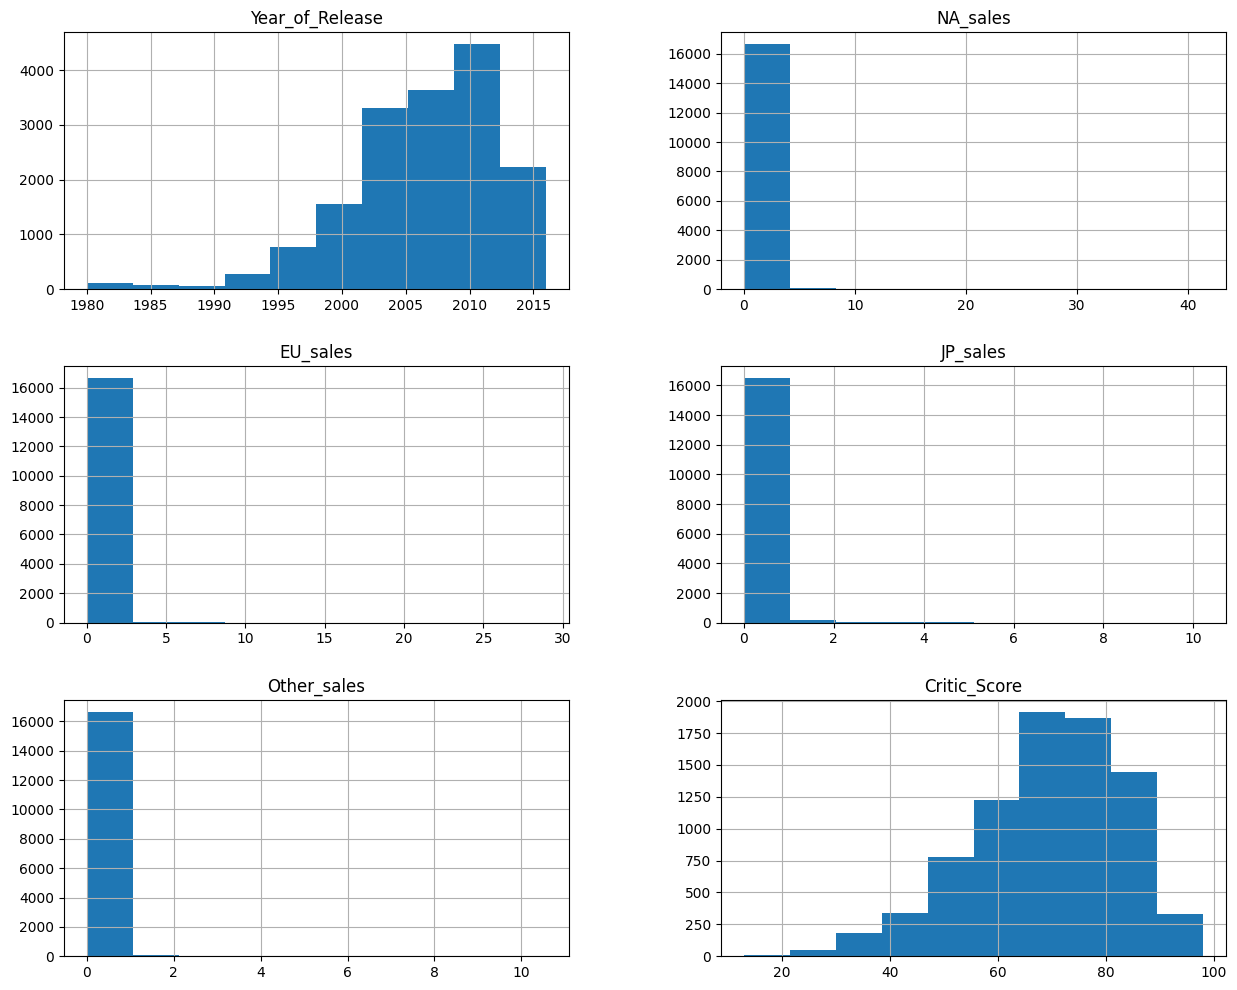

In [4]:
data.hist(figsize=(15, 12));

**Вывод:**  
Датафрейм состоит из 11 столбцов и 16715 строк.  
В 5 столбцах имеются пропущенные значения, в некоторых - некорректный тип данных.  
По ряду признаков присутствуют выбивающиеся значения, что видно по гистограммам.  
Кроме того, наименования столбцов не соответствуют стилистике написания, предусмотренной в Python.
Принято решение проработать каждый столбец индивидуально. 

### Предобработка данных

####  Объявление функций, необходимых для проведения предобработки и  исследовательского анализа данных

##### Функция для отображения общей информации о столбце

Данная функция принимает в качестве аргумента датафрейм и название столбца и выводит основную информацию о столбце:   
    * наименование столбца, его описание на русском языке(в случает, если третим аргументом передан словарь содержащий необходимую информацию);  
    * тип данных;  
    * информацию о наличии пропусков и выбросов. 

In [5]:
def inform (data, columns, dict_1={}):
    if dict_1 == None:
        dict_1 = {}
    try:
        print(f'Столбец "{columns}" - "{dict_1[columns]}":')
    except:
        print(f'Столбец "{columns}":')
    print(f'\tТип данных: {data[columns].dtype}')
    print(f'\tКоличество уникальных значений: {data[columns].nunique()}.')
    if data[columns].isna().sum() == 0:
        print('\tПропуски отсутствуют.')
    else: 
        print(f'\tКоличество пропусков в столбце: {data[columns].isna().sum()} ({data[columns].isna().sum()/len(data):.2%}).')
    try:
        q1,q3 = data[columns].quantile(0.25), data[columns].quantile(0.75)
        iqr = q3 - q1
        data1 = data.loc[(data[columns] < (q3 + 1.5*iqr)) & (data[columns] > (q1 - 1.5*iqr))]
        length = len(data1)+data[columns].isna().sum()
        if length == len(data):
            print('\tВыбросы отсутствуют.')
        else:
            print(f'\tКоличество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
    except:
        pass
    print('-'*45)

In [6]:
names = {'name': 'Название игры',
         'platform': 'Игровая платформа',
         'year_of_release': 'Год релиза',
         'genre': 'Жанр игры',
         'na_sales': 'Продажи в Северной Америке (миллионы проданных копий)',
         'eu_sales': 'Продажи в Европе (миллионы проданных копий)',
         'jp_sales': 'Продажи в Японии (миллионы проданных копий)',
         'other_sales': 'Продажи в других странах (миллионы проданных копий)',
         'critic_score': 'Оценка критиков (максимум 100)',
         'user_score': 'Оценка пользователей (максимум 10)',
         'rating': 'Рейтинг от организации ESRB',
        'sales_cat': 'Категория игры'}

##### Функция для отображения наличия рейтинга и оценок в зависимости от различных критериев

Функция, применимая только в рамках данного проекта.  
Принимает в качестве аргумента наименование столбца с оценками(рейтингом), и возвращает диаграммы, содержащие информацию о наличии оценок(рейтинга игр) в зависимости от различных факторов.

In [7]:
title = {'critic_score': 'Доля игр с оценкой критиков ',
         'user_score': 'Доля игр с оценкой пользователей',
         'rating': 'Доля игр с с выявленным рейтингом'}
title_2 = {'year_of_release': 'года релиза',
          'platform': 'платформы',
          'genre': 'жанра',
          'sales_cat': 'категории'}

def rating(col_1):
    data_y = data[['name',col_1, 'year_of_release']]
    data_y['is missed'] = data_y[col_1].notna()
    data_p = data[['name',col_1, 'platform']]
    data_p['is missed'] = data_p[col_1].notna()
    data_g = data[['name',col_1, 'genre']]
    data_g['is missed'] = data_g[col_1].notna()
    data_s = data[['name',col_1, 'sales_cat']]
    data_s['is missed'] = data_s[col_1].notna()
    t1 = data_y.pivot_table(index = 'year_of_release', values = 'is missed').reset_index()
    t2 = data_p.pivot_table(index = 'platform', values = 'is missed').reset_index()
    t3 = data_g.pivot_table(index = 'genre', values = 'is missed').reset_index()
    t4 = data_s.pivot_table(index = 'sales_cat', values = 'is missed').reset_index()
    dict_1 = {1:'year_of_release', 2:'platform', 3:'genre', 4:'sales_cat'}
    plt.figure(figsize=(15, 10))
    n = 1
    for i in [t1, t2, t3, t4]:
        ind = dict_1[n]
        plt.subplot(2, 2, n)
        plt.tight_layout(h_pad= 2 )
        plt.bar(i[ind], i['is missed'])
        plt.grid(b=True)
        plt.title(f'{title[col_1]} в зависимости от {title_2[ind]}')
        plt.xlabel(names[ind])
        plt.ylabel('Доля игр с заполненным значением')
        plt.xticks(rotation = 60)
        n +=1

##### Функция для составления портрета пользователя региона

Функция, применимая только в рамках данного проекта.
Принимает в качестве аргумента наименование столбца с суммой продаж по региону, и возвращает диаграммы, содержащие информацию о распределении предпочтений пользователей по платформам, жанрам и в соответствие с рейтингом ESRB.

In [8]:
def user_portrait(columns):
    platform = (data_act.pivot_table(index = 'platform', values = columns, aggfunc = 'sum')
               .sort_values(columns, ascending = False)
               .reset_index()
               .loc[:4])
    sum_p = (data_act.pivot_table(index = 'platform', values = columns, aggfunc = 'sum')
             .sort_values(columns, ascending = False)
             .iloc[5:]
             .sum()[0])
    platform.loc[5] = ['Оther(Прочие)', sum_p]
    rating = (data_act.pivot_table(index = 'rating', values = columns, aggfunc = 'sum')
               .sort_values(columns, ascending = False)
               .reset_index())
    genre = (data_act.pivot_table(index = 'genre', values = columns, aggfunc = 'sum')
               .sort_values(columns, ascending = False)
               .reset_index()
               .loc[:4])
    sum_g = (data_act.pivot_table(index = 'genre', values = columns, aggfunc = 'sum')
             .sort_values(columns, ascending = False)
             .iloc[5:]
             .sum()[0])
    genre.loc[5] = ['Оther(Прочие)', sum_g]
    plt.figure(figsize=(15, 15))
    plt.rcParams['font.size'] = 13.0
    plt.subplot(2, 2, 1) 
    plt.pie(platform[columns], labels=platform['platform'],autopct='%.0f%%')
    plt.title('Топ-5 игровых платформ:')
    
    plt.subplot(2, 2, 2)
    plt.pie(genre[columns], labels=genre['genre'], autopct='%.0f%%')
    plt.title('Топ-5 игровых жанров:')
    
    plt.subplot(2, 2, 3)
    plt.pie(rating[columns], labels=rating ['rating'],autopct='%.0f%%')
    plt.title('Топ игр по рейтингу ESRB:')
    plt.show()

##### Функция для визуализации  глобальных продаж игр  по платформам

Функция, применимая только в рамках данного проекта. Принимает в качестве аргумента наименование игровой платформы и возвращает диаграммы размаха суммы продаж по платформе(в целом по столбцу и с учетом ограничения по диапазону), а также диаграммы рассеяния, отражающие зависимость между суммой продаж по платформе от пользовательских оценок и оценок критиков.

In [9]:
def platform_info(name, lim = 2):
    d_p = data_act.query('platform == @name')
    data_c= d_p.pivot_table(index = 'critic_score', values = 'total_sales').reset_index()
    data_u= d_p.pivot_table(index = 'user_score', values = 'total_sales').reset_index()
    plt.figure(figsize=(15, 10))
    plt.rcParams['font.size'] = 11.0
    plt.subplot(2, 2, 1)
    plt.boxplot(d_p['total_sales'])
    plt.ylabel('Сумма продаж')
    plt.title(f'Объем продаж игр для платформы {name}')
   
    plt.subplot(2, 2, 2)
    plt.boxplot(d_p['total_sales'])
    plt.title(f'Объем продаж игр для платформы {name}')
    plt.ylabel('Сумма продаж')
    plt.ylim(0,lim)
    
    plt.subplot(2, 2, 3)
    plt.scatter(x=data_u['user_score'], y=data_u['total_sales'], alpha=0.6)
    plt.title('Зависимость между объемом продаж и оценкой пользователей')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Сумма продаж')
    
    plt.subplot(2, 2, 4)
    plt.scatter(x=data_c['critic_score'], y=data_c['total_sales'], alpha=0.6)
    plt.title('Зависимость между объемом продаж и оценкой критиков')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Сумма продаж')
    plt.show()
    
    print(f'Описательная статистика:', d_p['total_sales'].describe(), sep = '\n')
    print()
    print(f'Зависимость между объемом продаж и оценкой пользователей:\n\n {data_u.corr()}\n')
    print(f'Зависимость между объемом продаж и оценкой критиков:\n\n {data_c.corr()}')

####  Общие операции с датафреймом

#####  Корректировка наименований столбцов

Откорректируем наименования столбцов. Приведем их в змеиный регистр.

In [10]:
data.rename(columns = {i:i.lower() for i in data.columns}, inplace = True)

Уточним корректность результата 

In [11]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Вывод:** Наименования столбцов приведены в корректное состояние.

##### Выявление явных дубликатов

In [12]:
data.duplicated().sum() 

0

**Вывод:** Явные дубликаты отсутствуют.

##### Добавление необходимых столбцов

Добавим столбец с суммарными продажами по всем регионам.

In [13]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

А также столбец с категорией игры в зависимости от общей суммы продаж.

In [14]:
q1,q2,q3 = data['total_sales'].quantile(0.25), data['total_sales'].quantile(0.5), data['total_sales'].quantile(0.75)

def categorize(row):
    try:
        if row > q3:
            return 'Хиты'
        elif row > q2:
            return 'Популярные'
        elif row > q1:
            return 'Непопулярные'
        else:
            return 'Невостребованные'
    except:
        return 'Категория не определена'

In [15]:
data['sales_cat'] = data['total_sales'].apply(categorize)

Проверим корректность добавления столбцов.

In [16]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,sales_cat
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54,Хиты
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,Хиты
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,Хиты
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77,Хиты
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,Хиты


**Вывод:** Необходимые столбцы добавлены.

Зафиксируем количество строк в исходном датафрейме.

In [17]:
row_q = data.shape[0]

#### Работа со столбцами


##### Столбец "name"

In [18]:
inform(data, 'name', names)

Столбец "name" - "Название игры":
	Тип данных: object
	Количество уникальных значений: 11559.
	Количество пропусков в столбце: 2 (0.01%).
---------------------------------------------


В датафрейме всего 2 строки с пропусками в столбце 'name'. Рассмотрим их подробнее.

In [19]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,sales_cat
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39,Хиты
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03,Невостребованные


Помимо пропусков в названии игры, данные строки не содержат информации о жанре, рейтинге, а также пользовательских оценках и оценках критиков. В данном случае эти строки целесообразно удалить.

In [20]:
data = data.dropna(subset =['name'])

**Вывод:**  
Строки с пропущенными значениями удалены. Тип данных корректировки не требует.

##### Столбец "platform" 

In [21]:
inform(data, 'platform', names)

Столбец "platform" - "Игровая платформа":
	Тип данных: object
	Количество уникальных значений: 31.
	Пропуски отсутствуют.
---------------------------------------------


Визуально проанализируем уникальные значения на предмет наличия неявных дубликатов.

In [22]:
data['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

**Вывод:**  
Столбец корректировки не требует.

#####  Столбец "year_of_release"

In [23]:
inform(data, 'year_of_release', names)

Столбец "year_of_release" - "Год релиза":
	Тип данных: float64
	Количество уникальных значений: 37.
	Количество пропусков в столбце: 269 (1.61%).
	Количество выбросов в столбце: 305 (1.82%).
---------------------------------------------


Для определения возможности заполнения пропусков в столбце 'year_of_release' рассмотрим сводную таблицу, в которой для каждой из игр укажем количество платформ, на которой она выходила, годы первого и последнего релиза игры, а также разницу(количество лет) между первым и последним релизом игры.
Выведем данную таблицу в 2 вариантах сортировки:
- по убыванию количества платформ, на которых вышла игра,
- по убыванию разницы между датами первого и последнего релиза игры.

In [24]:
data_release = data.pivot_table(index = 'name', values = 'year_of_release', aggfunc = ['count', 'min', 'max']).reset_index()
data_release.columns = ['Название игры','Количество платформ', 'Первый год релиза', 'Последний год релиза']
data_release['Количество лет релиза'] = data_release['Последний год релиза'] - data_release['Первый год релиза']
display(data_release.sort_values('Количество платформ', ascending = False).head(10))
data_release.sort_values('Количество лет релиза', ascending = False).head(10)

,Название игры,Количество платформ,Первый год релиза,Последний год релиза,Количество лет релиза
6715,Need for Speed: Most Wanted,12,2005.0,2013.0,8.0
7785,Ratatouille,9,2007.0,2007.0,0.0
5143,LEGO Marvel Super Heroes,9,2013.0,2013.0,0.0
2952,FIFA 14,9,2013.0,2013.0,0.0
5140,LEGO Jurassic World,8,2015.0,2015.0,0.0
2969,FIFA Soccer 13,8,2012.0,2012.0,0.0
5470,Madden NFL 07,8,2006.0,2006.0,0.0
9990,The LEGO Movie Videogame,8,2014.0,2014.0,0.0
1306,Cars,8,2006.0,2006.0,0.0
9763,Terraria,8,2011.0,2016.0,5.0


,Название игры,Количество платформ,Первый год релиза,Последний год релиза,Количество лет релиза
748,Battlezone,3,1982.0,2016.0,34.0
8098,Romance of the Three Kingdoms II,2,1991.0,2015.0,24.0
977,Bomberman,4,1985.0,2008.0,23.0
3179,Final Fantasy III,4,1990.0,2012.0,22.0
5293,Lode Runner,2,1984.0,2006.0,22.0
7578,Pro Yakyuu Family Stadium,2,1986.0,2008.0,22.0
2034,Defender,4,1980.0,2002.0,22.0
6146,Mortal Kombat,5,1992.0,2012.0,20.0
1020,Boxing,2,1980.0,2000.0,20.0
9537,Syndicate,3,1992.0,2012.0,20.0


Выведем распределение игр в зависимости от количества платформ, на которых они выходили.

In [25]:
data_release['Количество платформ'].value_counts()

1     8678
2     1502
3      696
4      278
5      140
0      133
6       86
7       29
8       13
9        3
12       1
Name: Количество платформ, dtype: int64

А также распределение игр в зависимости от количества лет релиза.

In [26]:
data_release['Количество лет релиза'].value_counts()

0.0     10732
1.0       371
2.0        96
3.0        43
4.0        30
5.0        28
10.0       16
6.0        16
13.0       14
8.0        13
9.0        11
7.0        11
11.0        9
12.0        9
15.0        4
22.0        4
20.0        3
14.0        3
17.0        3
16.0        3
18.0        2
19.0        2
23.0        1
24.0        1
34.0        1
Name: Количество лет релиза, dtype: int64

Рассчитаем долю игр, релиз которых осуществлялся за пределами одного календарного года.

In [27]:
len(data_release[data_release['Количество лет релиза'] != 0])/len(data_release)

0.07154598148628774

***Промежуточный вывод:***

Не смотря на то, что релиз абсолютного большинства игр на различных платформах осуществлялся в пределах одного календарного года, заполнение пропусков какой либо мерой центральной тенденции может привести к возникновению явно аномальных значений (релизу игры в год когда платформа еще не вышла на рынок или утратила свою актуальность).
Корректное заполнение пропусков в столбце требует учета множества факторов. Так как  пропущенные значения присутствуют всего в 1,61% строк датафрейма, целесообразнее строки с пропусками удалить.

In [28]:
data = data.dropna(subset =['year_of_release'])

Откорректируем тип  данных.

In [29]:
data['year_of_release'] = data['year_of_release'].astype(int)

In [30]:
inform(data, 'year_of_release', names)

Столбец "year_of_release" - "Год релиза":
	Тип данных: int32
	Количество уникальных значений: 37.
	Пропуски отсутствуют.
	Количество выбросов в столбце: 305 (1.85%).
---------------------------------------------


***Вывод:***
Строки с пропущенными значениями в столбце удалены.  
Тип данных приведен в целочисленный формат.  
Работа с выбросами не требуется. 

##### Столбец 'genre'

In [31]:
inform(data, 'genre', names)

Столбец "genre" - "Жанр игры":
	Тип данных: object
	Количество уникальных значений: 12.
	Пропуски отсутствуют.
---------------------------------------------


Визуально проанализируем уникальные значения на предмет наличия неявных дубликатов.

In [32]:
data['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

***Вывод:***
Корректировка столбца не требуется.

##### Столбец 'na_sales'

In [33]:
inform(data, 'na_sales', names)

Столбец "na_sales" - "Продажи в Северной Америке (миллионы проданных копий)":
	Тип данных: float64
	Количество уникальных значений: 401.
	Пропуски отсутствуют.
	Количество выбросов в столбце: 1693 (10.30%).
---------------------------------------------


***Вывод:***
Корректировка столбца не требуется.

##### Столбец 'jp_sales'

In [34]:
inform(data, 'jp_sales', names)

Столбец "jp_sales" - "Продажи в Японии (миллионы проданных копий)":
	Тип данных: float64
	Количество уникальных значений: 244.
	Пропуски отсутствуют.
	Количество выбросов в столбце: 2569 (15.62%).
---------------------------------------------


Рассмотрим минимальное и максимальное значение столбца.

In [35]:
display(data['jp_sales'].min())
data['jp_sales'].max()

0.0

10.22

В данном случае выбросы обусловлены наличием игр-бестселлеров, сумма продаж по которым намного превышает медианную по столбцу.  

***Вывод:***
Корректировка столбца не требуется.

##### Столбец 'eu_sales'

In [36]:
inform(data, 'eu_sales', names)

Столбец "eu_sales" - "Продажи в Европе (миллионы проданных копий)":
	Тип данных: float64
	Количество уникальных значений: 307.
	Пропуски отсутствуют.
	Количество выбросов в столбце: 2034 (12.37%).
---------------------------------------------


Рассмотрим минимальное и максимальное значение столбца.

In [37]:
display(data['eu_sales'].min())
data['eu_sales'].max()

0.0

28.96

Выбросы также обусловлены наличием игр-бестселлеров, сумма продаж по которым намного превышает медианную по столбцу.

***Вывод:***
Корректировка столбца не требуется.

##### Столбец 'other_sales'

In [38]:
inform(data, 'other_sales', names)

Столбец "other_sales" - "Продажи в других странах (миллионы проданных копий)":
	Тип данных: float64
	Количество уникальных значений: 155.
	Пропуски отсутствуют.
	Количество выбросов в столбце: 2216 (13.48%).
---------------------------------------------


Рассмотрим минимальное и максимальное значение столбца.

In [39]:
display(data['other_sales'].min())
data['other_sales'].max()

0.0

10.57

Выбросы также обусловлены наличием игр-бестселлеров, сумма продаж по которым намного превышает медианную по столбцу.

***Вывод:***
Корректировка столбца не требуется.

##### Столбец 'critic_score'

In [40]:
inform(data, 'critic_score', names)

Столбец "critic_score" - "Оценка критиков (максимум 100)":
	Тип данных: float64
	Количество уникальных значений: 81.
	Количество пропусков в столбце: 8461 (51.45%).
	Количество выбросов в столбце: 80 (0.49%).
---------------------------------------------


С целью выявления зависимости наличия оценки игр со стороны критиков, рассмотрим группировку по различным критериям. 

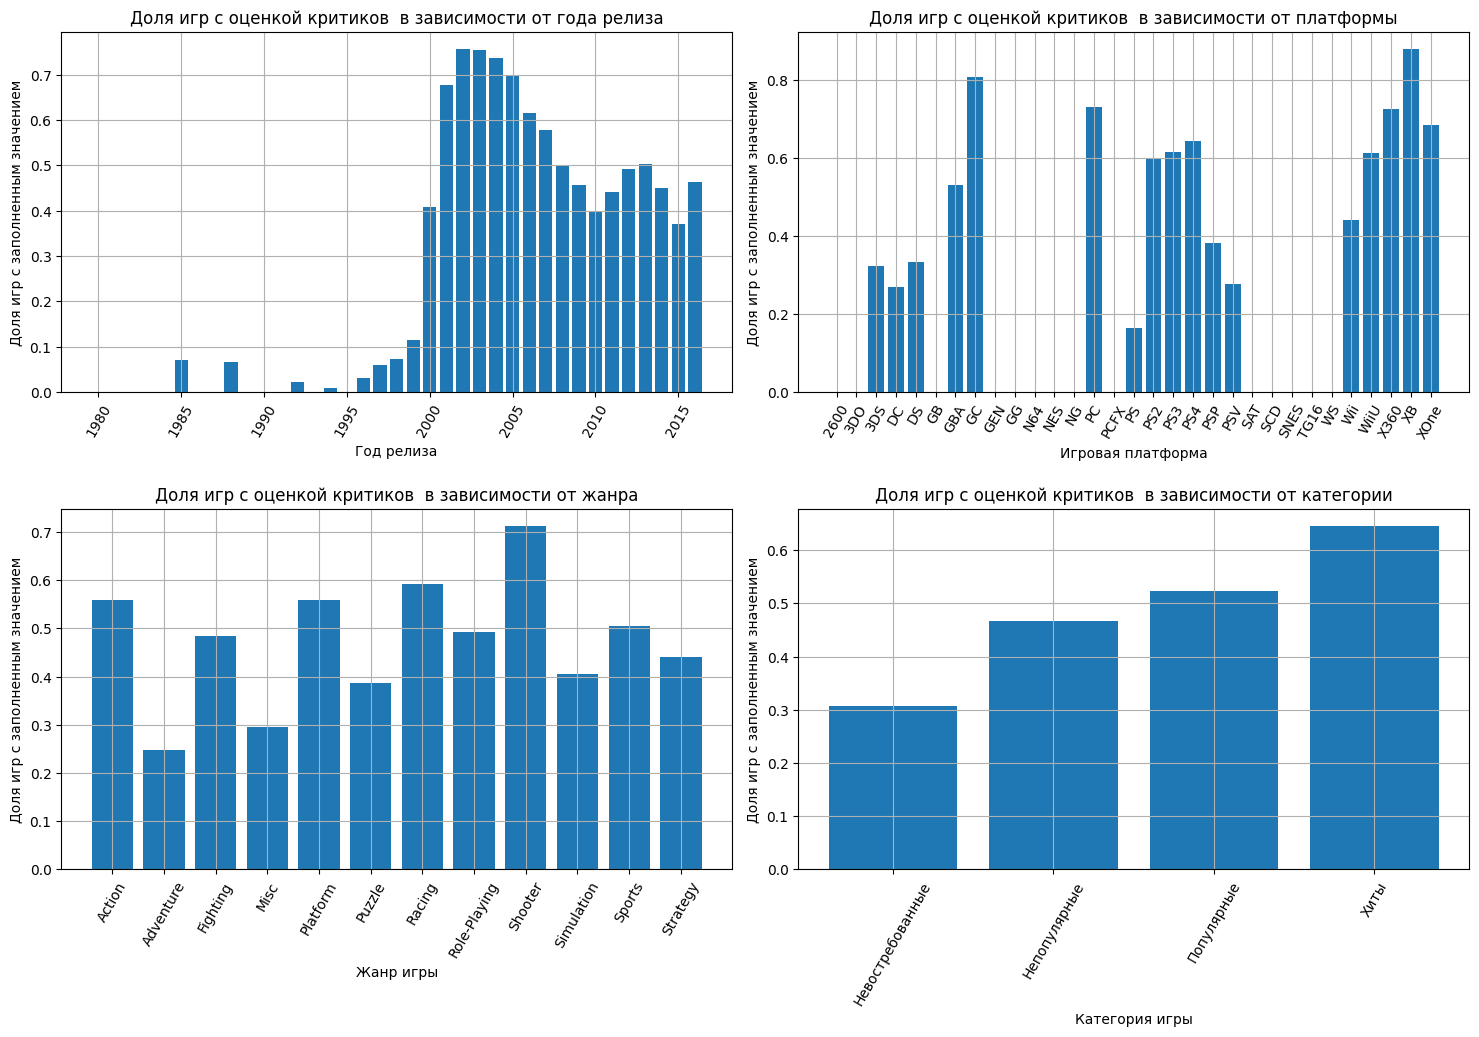

In [41]:
rating('critic_score')   

In [42]:
data['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

Как видно из графиков, наличие оценок критиков зависит от множества факторов, таких как год релиза, жанр игры, игровая платформа, категория игры(ее успешность на рынке). 
Заполнение пропусков в данном случае требует учета множества факторов и может привести к возникновению некорректных значений.
Целесообразно пропуски не заполнять.  
Уникальные значения находятся в рамках допустимого диапазона. Работа с выбросами не требуется.

**Вывод**: Столбец корректировки не требует.

##### Столбец 'user_score'

In [43]:
inform(data, 'user_score', names)

Столбец "user_score" - "Оценка пользователей (максимум 10)":
	Тип данных: object
	Количество уникальных значений: 96.
	Количество пропусков в столбце: 6605 (40.17%).
---------------------------------------------


Обращает на себя внимание несоответствие типа данных. Для выявления причин, рассмотрим перечень уникальных значений столбца.

In [44]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В перечне уникальных значений столбца присутствует абревиатура 'tbd'.
Изучив необходимую информацию выявлено, что 'tbd' - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). В данном случае данная абревиатура означает, что на момент выгрузки данных оценка пользователей еще не определена. Целесообразно заменить данное значение на пропуски.

In [45]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.NaN

In [46]:
data['user_score'] = data['user_score'].astype(float)

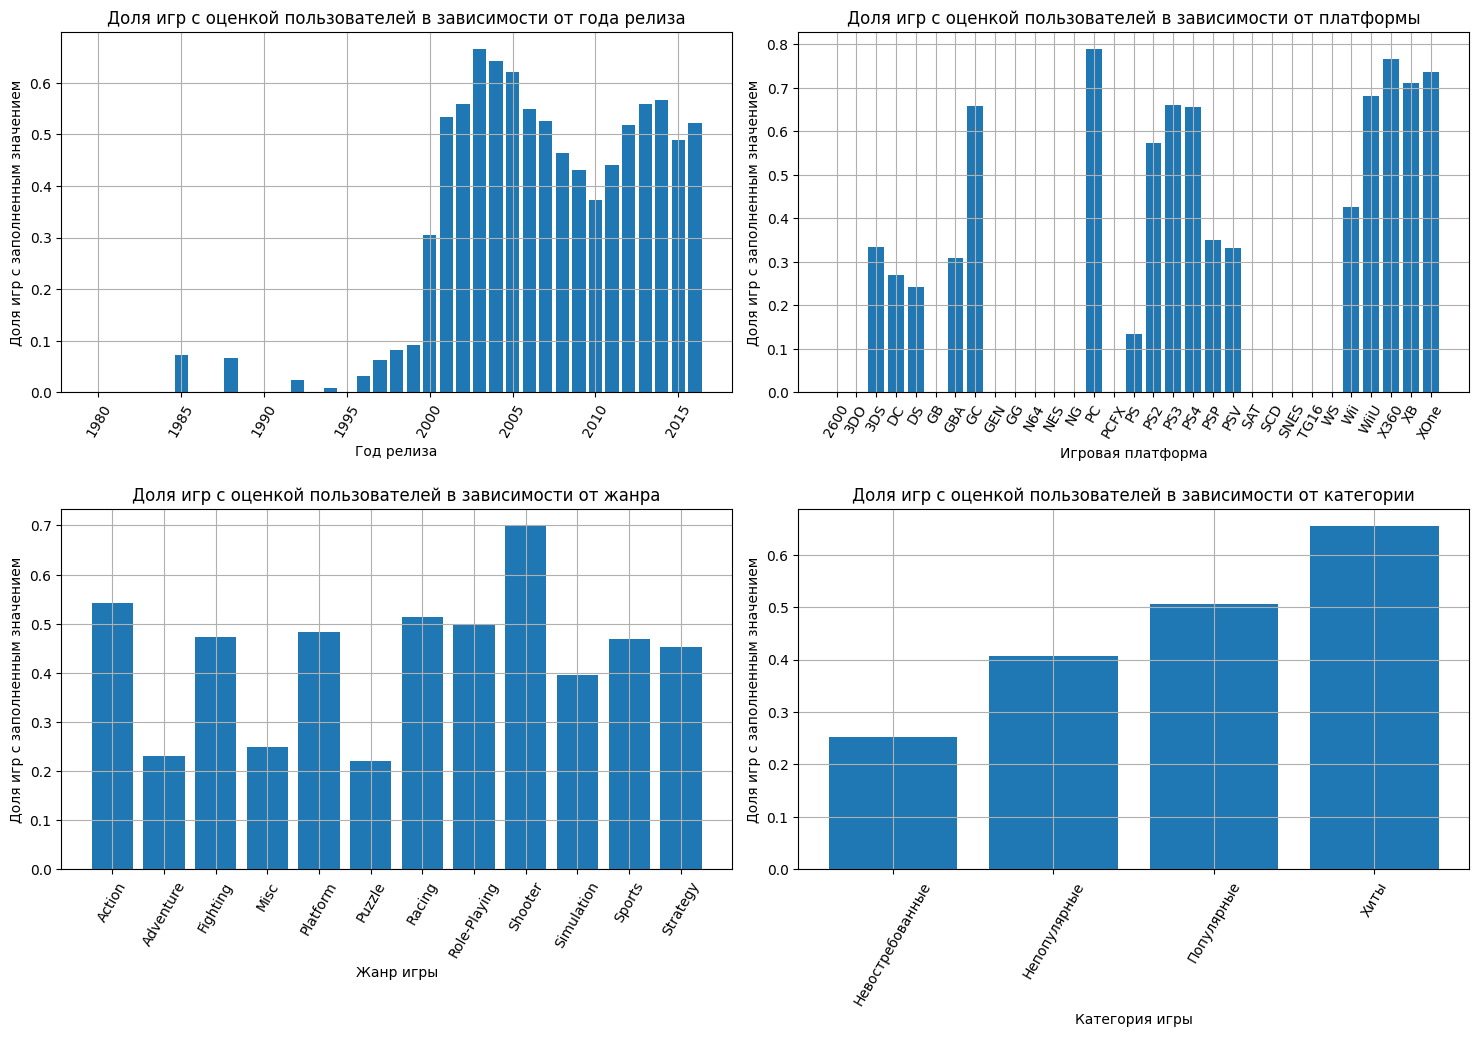

In [47]:
rating('user_score')

В данном случае также целесообразно работу с пропусками не проводить.

**Вывод:** Столбец корректировки не требует.

##### Столбец 'rating'

In [48]:
inform(data, 'rating', names)

Столбец "rating" - "Рейтинг от организации ESRB":
	Тип данных: object
	Количество уникальных значений: 8.
	Количество пропусков в столбце: 6676 (40.60%).
---------------------------------------------


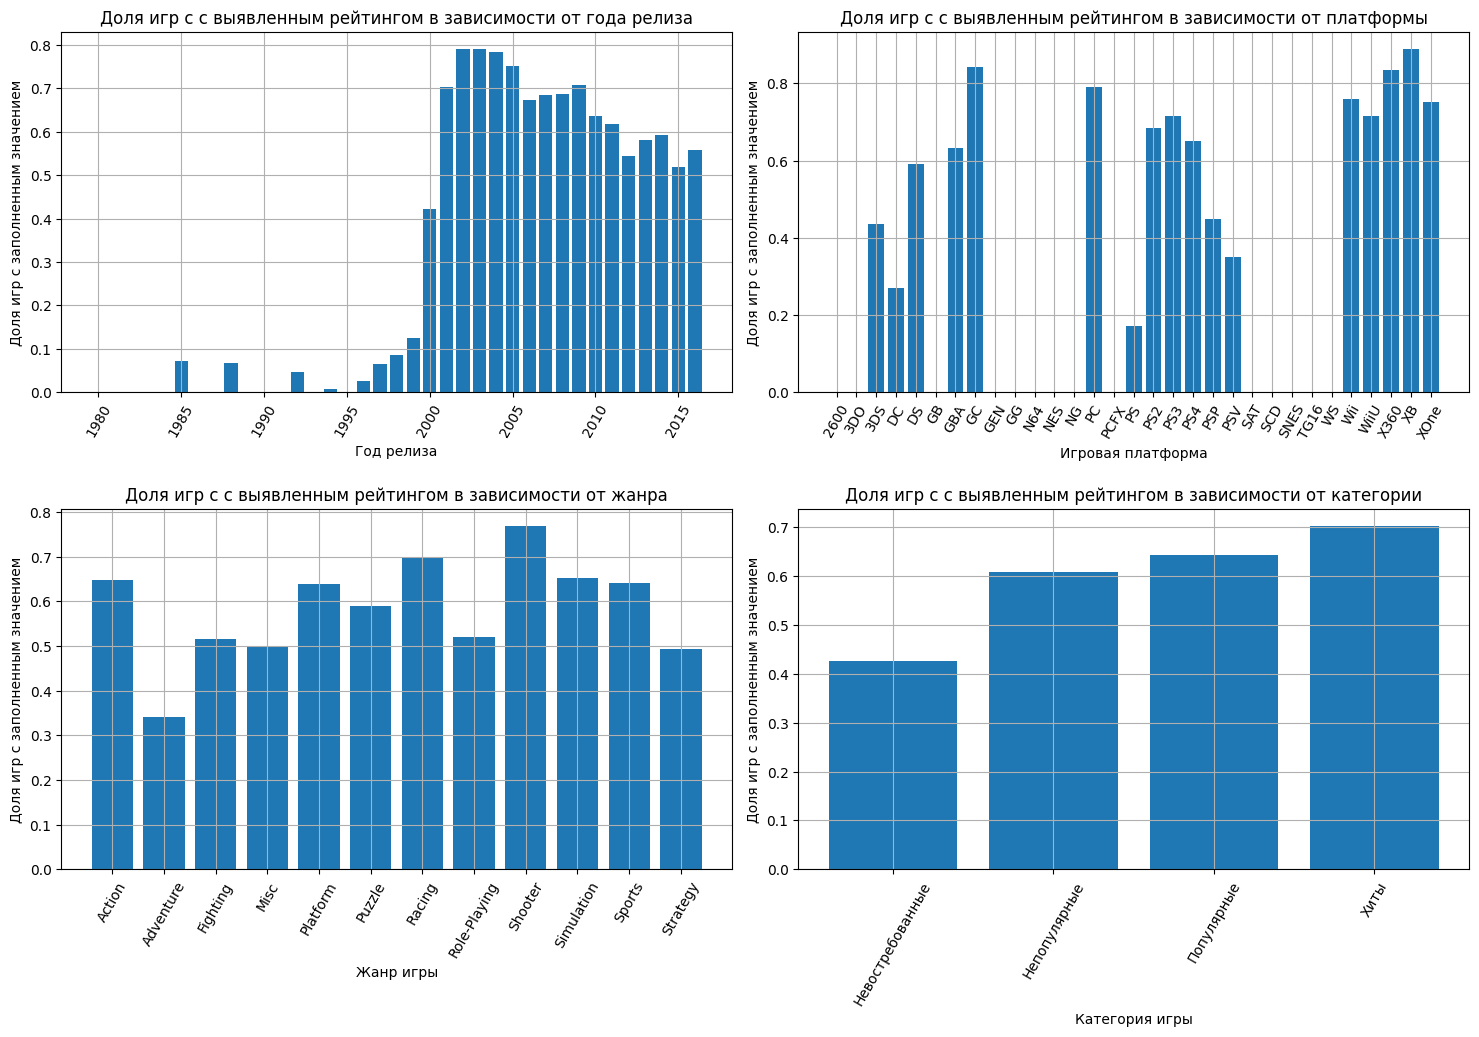

In [49]:
rating('rating')

In [50]:
data['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

В данном случае корректнее всего будет заполнить пропуски значением 'Unknown'(рейтинг не определен)

In [51]:
data['rating'] = data['rating'].fillna('Unknown')

In [52]:
inform(data, 'rating', names)

Столбец "rating" - "Рейтинг от организации ESRB":
	Тип данных: object
	Количество уникальных значений: 9.
	Пропуски отсутствуют.
---------------------------------------------


In [53]:
print(f'Удалено {((row_q - data.shape[0])/row_q):.1%} строк от исходного датафрейма')

Удалено 1.6% строк от исходного датафрейма


##### Общий вывод:
В результате предобработки данных проанализированы все столбцы датафрейма.
Наименования столбцов приведены в корректный вид.
Удалены строки с пропущенными значениями в столбцах 'name' и 'year_of_release'. 
В столбце 'rating' пропуски заполнены значением 'Unknown'(рейтинг не определен)
По отношению к остальным столбцам принято решение пропуски не корректировать.
Произведена корректировка типов данных по следующим столбцам:
- "year_of_release" переведен  целочисленный формат;
- "user_score" - в формат числа с плавающей точкой.


В целом по итогам предобработки удалено 1,6% строк.

Можно обозначить 2 предполагаемые причины пропущенных значений:
1. Некорректное внесение информации о игре (название и год релиза). 
2. Отсутствие или недостаточное количество информации для определения среднего значения пользовательских оценок и оценок критиков по некоторым играм. Сюда же отношу отсутствие информации о рейтинге игры. 


### Исследовательский анализ данных

#### Исследование распределения количества выпущенных игр по годам

Построим гистограмму распределения количества выпущенных игр по годам.

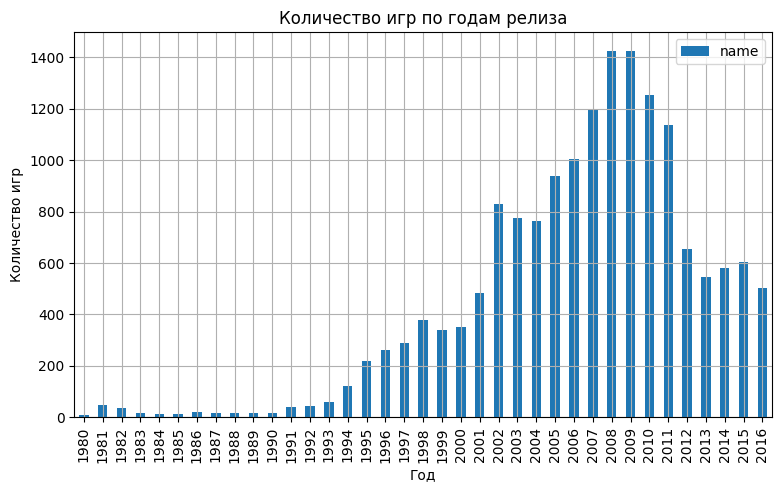

In [54]:
(data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = "count")
 .reset_index()
 .plot(y='name', x='year_of_release', kind='bar', grid = True, figsize = (9,5)))
plt.title('Количество игр по годам релиза')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

По гистограмме количества выпущенных игр видно, что в период до 1990 года ежегодное количество выпущенных игр было незначительным.  
Явная тенденция к росту проявляется с 1991 года. При этом пиковые значения приходятся на 2008-2009 год, в каждый из которых было выпущенно более 1400 игр.   
В последующие годы ежегодное количество релизов уменьшилось. С 2012 по 2016 год выходит примерно одинаковое количество игр, значение варьируется в пределах 600.
Снижение количества выпущенных игр с 2009 года я бы объяснил появлением на рынке мобильных устройств(смартфоны, планшеты), что вызвало  как отток пользователей традиционных игровых платформ, так и переориентацию некоторых разработчиков игр на игры для мобильных устройств.

#### Изменение продаж по платформам

Для изучения объемов продаж в разрезе платформ построим сводную таблицу, и выявим 10 наиболее успешных игровых платформ.

In [55]:
platforms = (data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                  .sort_values(by='total_sales', ascending=False).reset_index().loc[:10,'platform'])
platforms

0      PS2
1     X360
2      PS3
3      Wii
4       DS
5       PS
6      PS4
7      GBA
8      PSP
9      3DS
10      PC
Name: platform, dtype: object

Построим график объемов продаж 10 наиболее успешных платформ по годам.

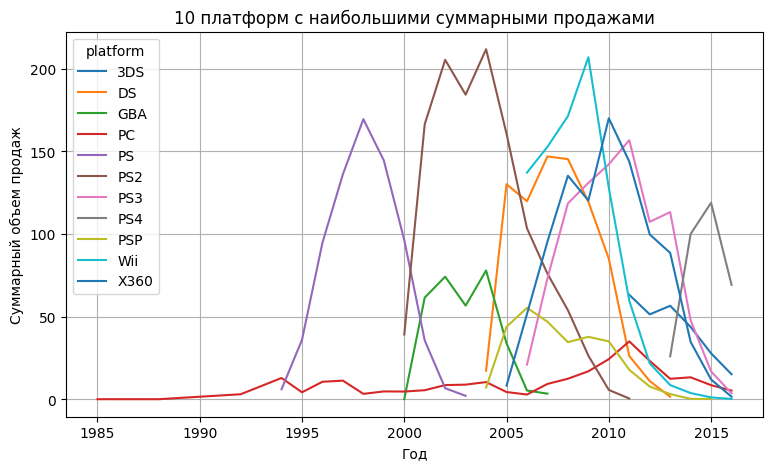

In [56]:
data.query('platform in @platforms').groupby(['platform', 'year_of_release'])['total_sales'].sum().unstack('platform').plot(
grid=True,figsize=(9,5))
plt.title('10 платформ с наибольшими суммарными продажами')
plt.xlabel('Год')
plt.ylabel('Суммарный объем продаж')
plt.show()

Дополнительно построим тепловую карту .

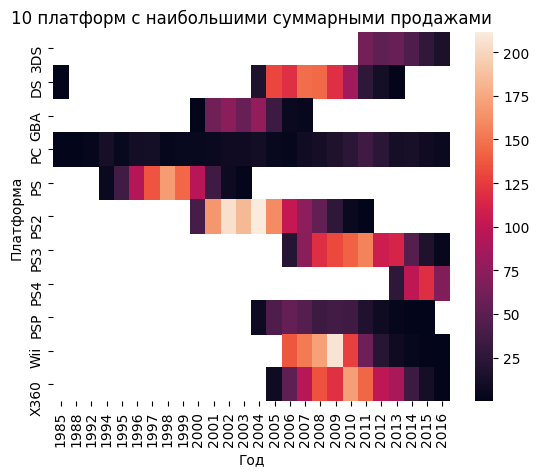

In [57]:
platf = data.query('platform in @platforms').pivot_table(index='platform', columns ='year_of_release', values='total_sales', aggfunc='sum')
sns.heatmap(platf)
plt.title('10 платформ с наибольшими суммарными продажами')
plt.xlabel('Год')
plt.ylabel('Платформа')
plt.show()

 **Вывод:** В среднем, "жизненный цикл" платформы составляет около 10 лет, с момента ее появления на рынке.

#### Определение актуального периода

При определении актуального периода учитываем 3 фактора:
1. Средний "жизненный цикл" платформы составляет около 10 лет, при этом во второй половине цикла наблюдается явная отрицательная тенденция. Для того, чтобы пики продаж по платформам, к 2016 году находящимся на исходе своей популярности, не оказывали влияние на цели исследования, актуальный период должен составлять менее 5 лет. 
2. Общую ситуацию на рынке игровой индустрии - необходимо учитывать только период, когда объем продаж относительно стабилизировался после появления на рынке мобильных устройств.
3. Резкое падение продаж игр для платформ  Sony PlayStation 3 и Microsoft Xbox 360 в 2014 году, по сравнению с 2013 годом (данные тепловой карты), что вызвано выходом на рынок платформ данных производителей следующего поколения. Включение в актуальный для целей исследования период 2013 год может повлечь смещение акцента на невостребованные в 2017 году платформы.  

Учитывая эти 3 фактора, актуальным определяем период с 2014 года.

In [58]:
data_act = data.query('year_of_release > 2013')

#### Определение потенциально прибыльных платформ

Построим график продаж объемов продаж 6 наиболее успешных платформ в рамках актуального для целей исследования периода.

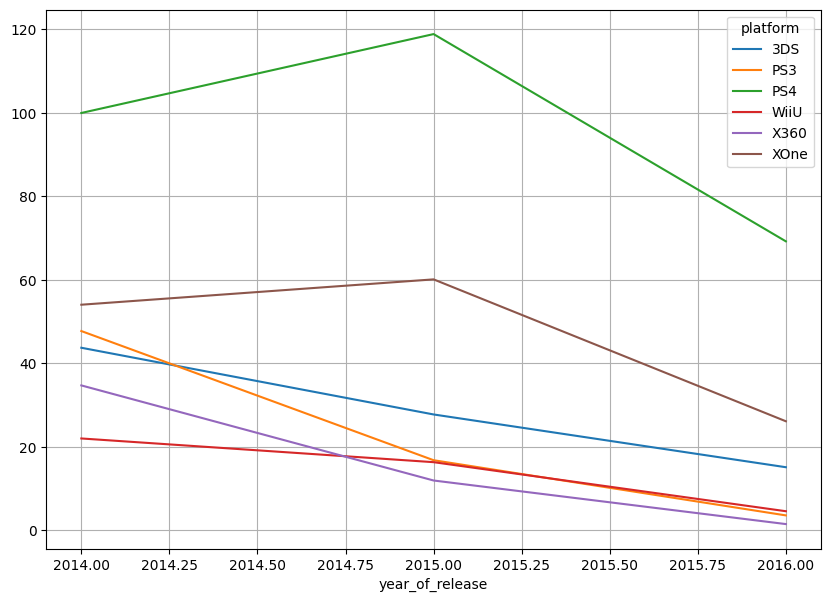

In [59]:
platforms = (data_act.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                  .sort_values(by='total_sales', ascending=False).reset_index().loc[:5,'platform'])
data_act.query('platform in @platforms').groupby(['platform', 'year_of_release'])['total_sales'].sum().unstack('platform').plot(
grid=True,figsize=(10,7));

Проанализировав график, и учитывая вероятность, что данные за 2016 год могут быть неполными, наиболее перспективными с точки зрения объемов продаж определяем следующие платформы:  

   * "PS4" - Sony PlayStation 4,
   * "XOne" - Microsoft Xbox One,
   * "3DS" - Nintendo 3DS,
   * "WiiU" - Nintendo Wii U,
   *  "PC"- персональные компьютеры. Так как данная платформа, не смотря на относительно невысокие объемы продаж, показывает  стабильность на всем протяжении развития рынка игровой индустрии.

#### Изучение глобальных продаж в разрезе игровых платформ

Рассмотрим каждую платформу индивидуально, используя ранее объявленную функцию.  
Так как, ввиду большого наличия выбросов, диаграмма размаха в целом по столбцу может быть не читаемой, дополнительно строим диаграмму размаха с ограничением диапазона  значений. 

Также рассмотрим зависимость продаж игр от оценок критиков и пользователей.


##### Продажи игр на "PS4"

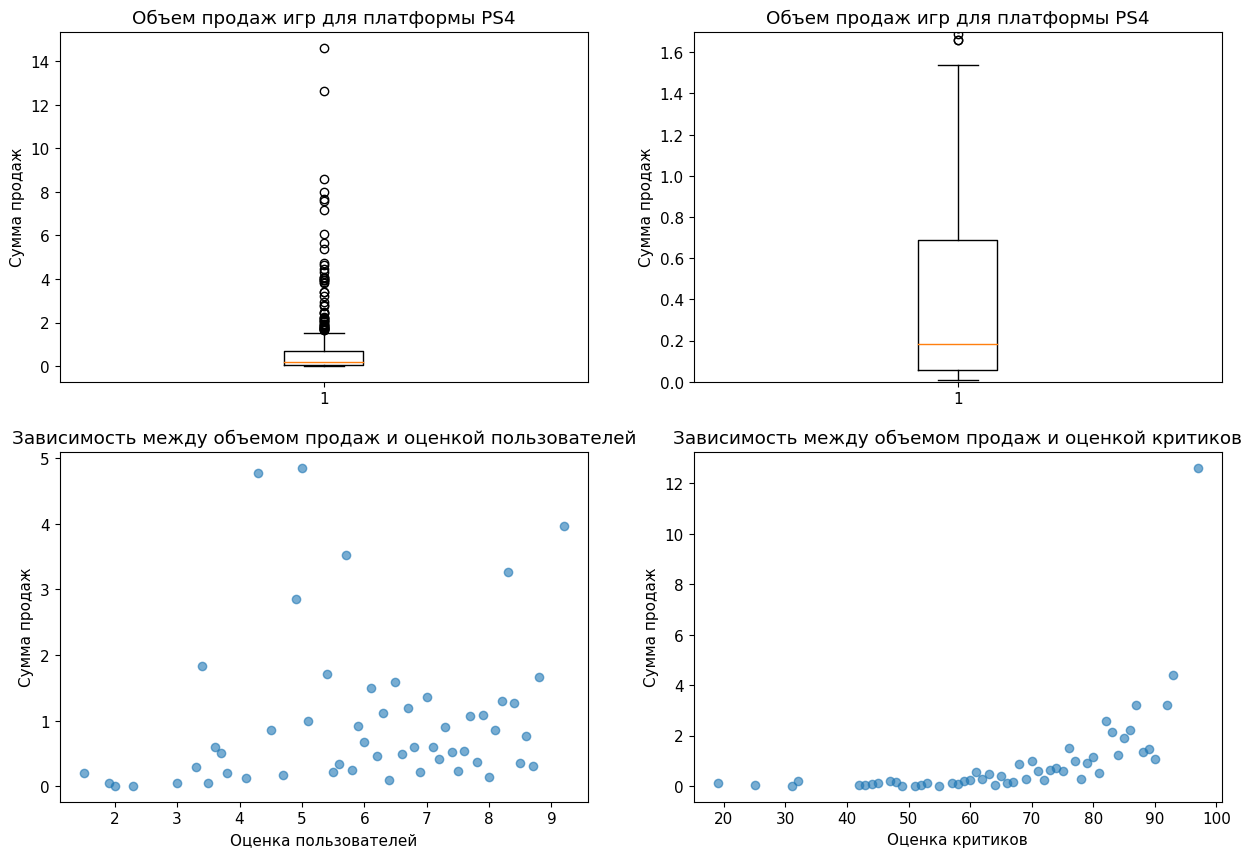

Описательная статистика:
count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: total_sales, dtype: float64

Зависимость между объемом продаж и оценкой пользователей:

              user_score  total_sales
user_score     1.000000     0.164997
total_sales    0.164997     1.000000

Зависимость между объемом продаж и оценкой критиков:

               critic_score  total_sales
critic_score      1.000000     0.553681
total_sales       0.553681     1.000000


In [60]:
platform_info("PS4",1.7)

**Вывод**: 
Для платформы "PS4" за актуальный период выпущено 376 игр. Медианное значение объемов продаж игр составляет 185 тыс. копий. Среднее значение - 766 тысяч. Такая разница обусловлена присутствием игр-бестселлеров, проданных тиражами в несколько миллионов копий. Максимальное значение объема продаж составляет 14,63 млн. копий. 

Корреляция между объемом продаж и оценками критиков средняя, составляет около 0,55. В то же время корреляция между объемом продаж и оценками пользователей крайне слабая  и составляет 0,17.

##### Продажи игр на "XOne"

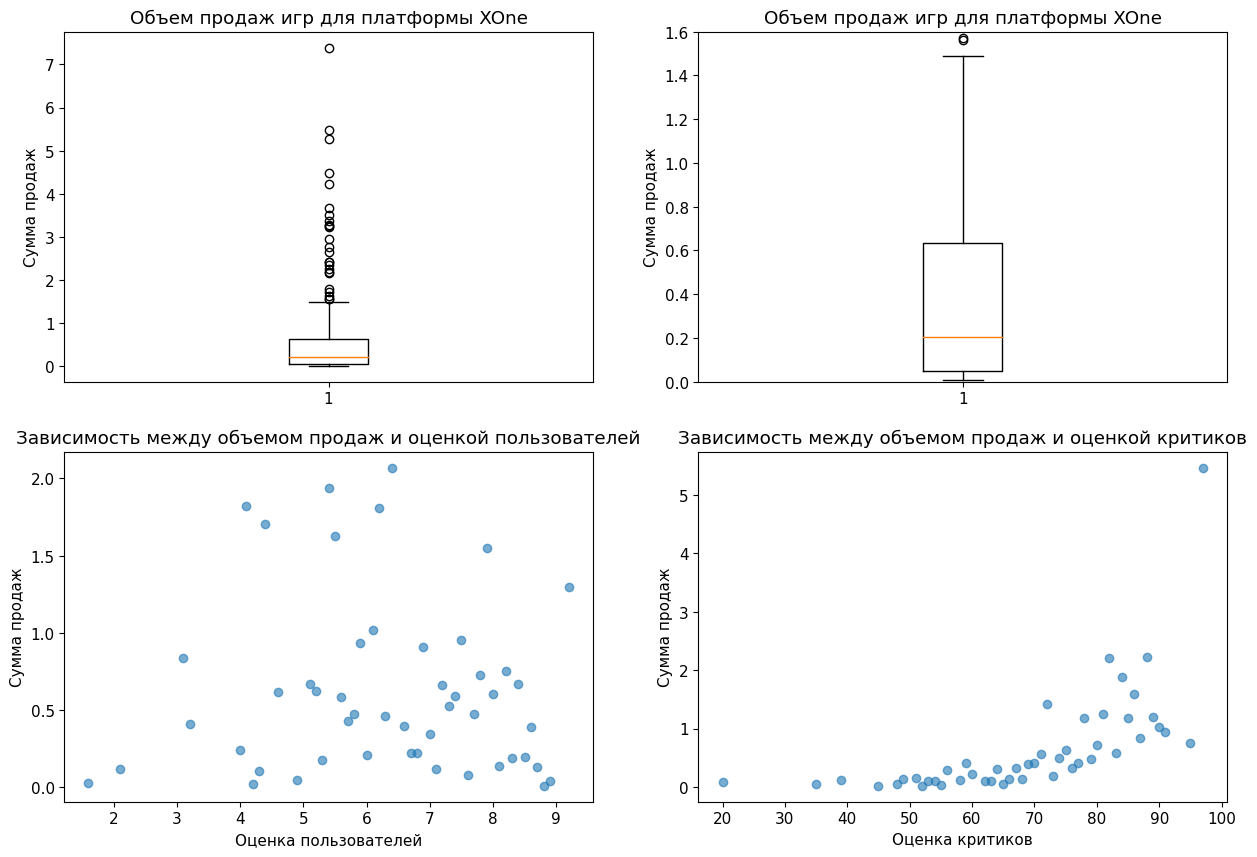

Описательная статистика:
count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64

Зависимость между объемом продаж и оценкой пользователей:

              user_score  total_sales
user_score     1.000000    -0.044792
total_sales   -0.044792     1.000000

Зависимость между объемом продаж и оценкой критиков:

               critic_score  total_sales
critic_score      1.000000     0.620387
total_sales       0.620387     1.000000


In [61]:
platform_info("XOne",1.6)   

**Вывод**: Для платформы "XOne" за актуальный период выпущено 228 игр. Медианное значение объемов продаж игр составляет 205 тыс. копий. Среднее значение - 616 тысяч. 
Максимальное значение - 7,39 млн.
Корреляция между объемом продаж и оценками критиков средняя, составляет около 0,62. В то же время корреляция между объемом продаж и оценками пользователей практически отсутствует - 0,04.

##### Продажи игр на "3DS"

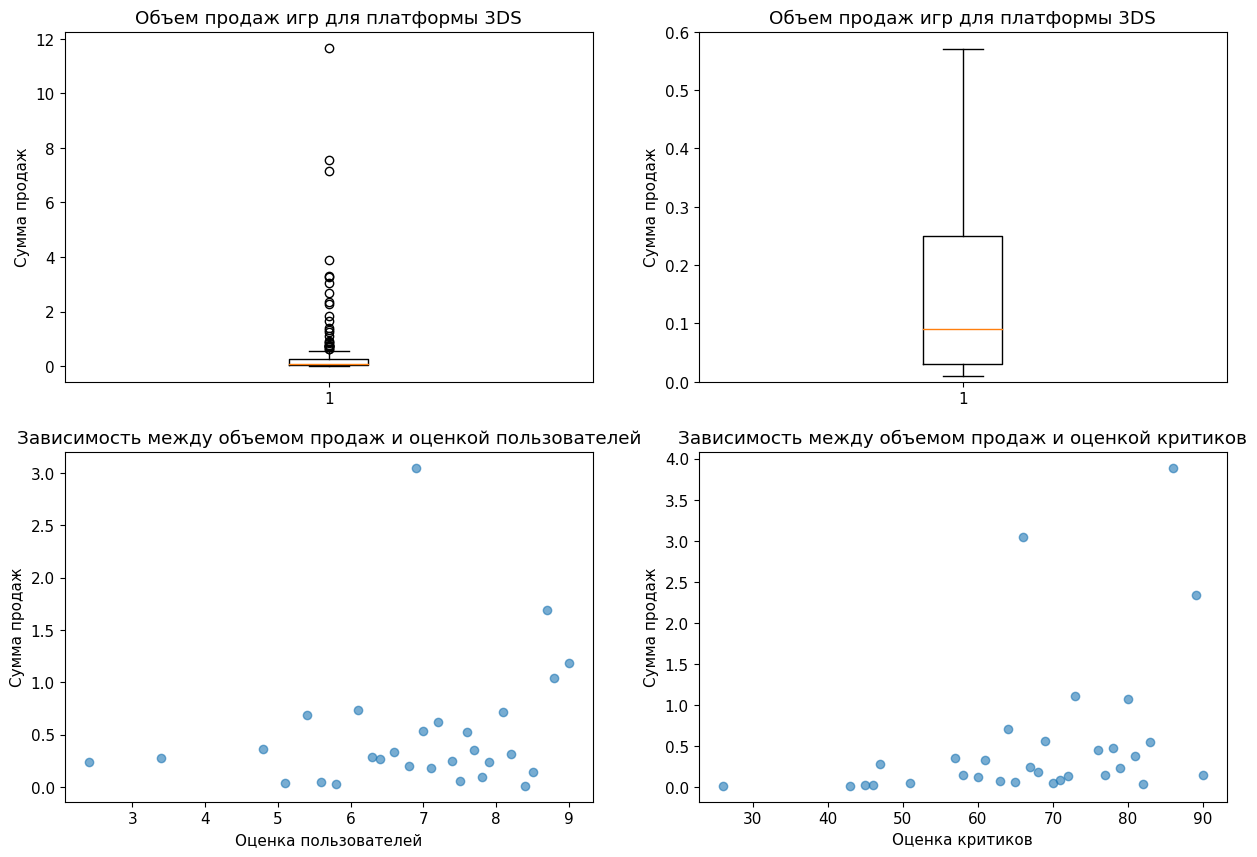

Описательная статистика:
count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: total_sales, dtype: float64

Зависимость между объемом продаж и оценкой пользователей:

              user_score  total_sales
user_score     1.000000     0.226035
total_sales    0.226035     1.000000

Зависимость между объемом продаж и оценкой критиков:

               critic_score  total_sales
critic_score      1.000000     0.380699
total_sales       0.380699     1.000000


In [62]:
platform_info("3DS", 0.6)   

 **Вывод**: Для платформы "3DS" за актуальный период выпущено выпущено 212 игр.  Медианное значение объемов продаж игр составляет 90 тыс. копий. Среднее значение - 408 тысячи. Наибольший тираж - 11,68 млн. копий.
Корреляция между объемом продаж и оценками критиков средняя, составляет около 0,38 . В то же время корреляция между объемом продаж и оценками пользователей слабее - 0,22.

##### Продажи игр на "WiiU"

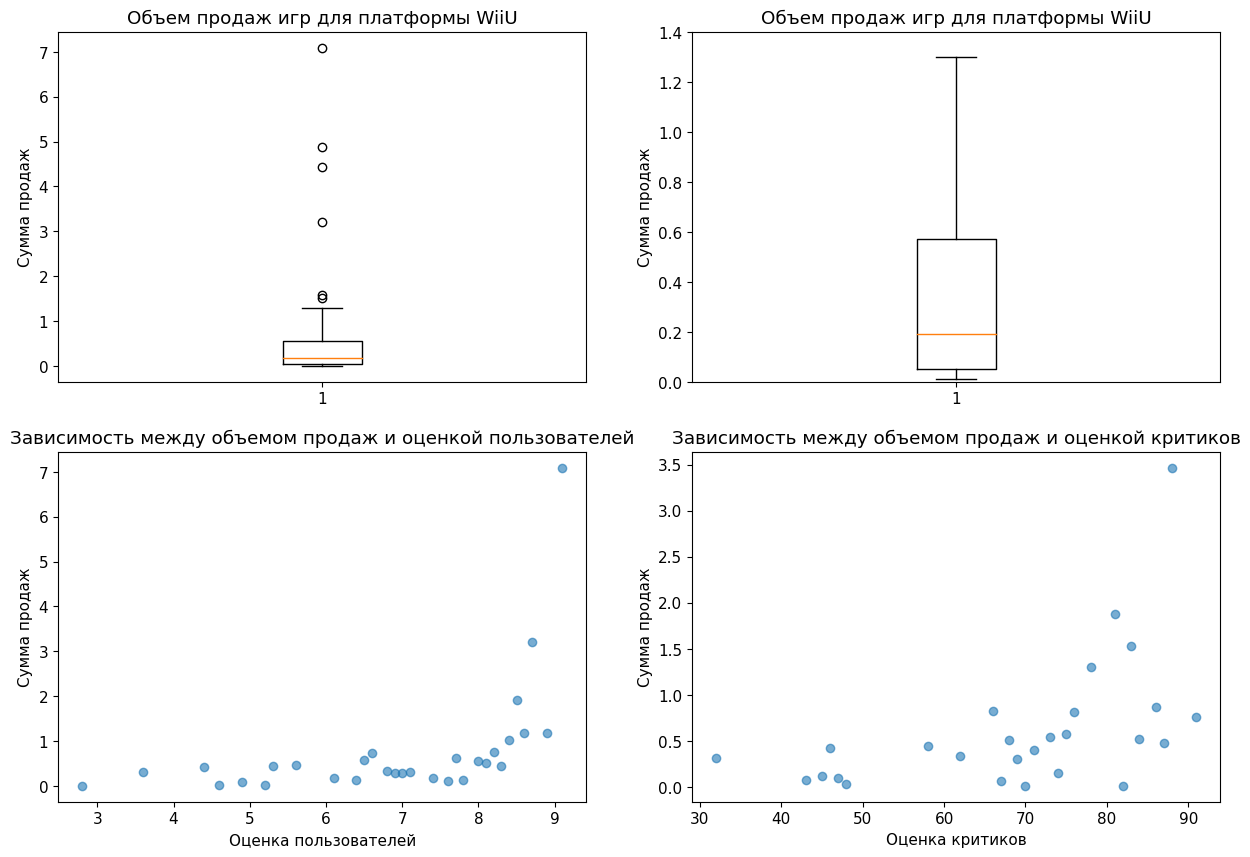

Описательная статистика:
count    73.000000
mean      0.588767
std       1.161467
min       0.010000
25%       0.050000
50%       0.190000
75%       0.570000
max       7.090000
Name: total_sales, dtype: float64

Зависимость между объемом продаж и оценкой пользователей:

              user_score  total_sales
user_score     1.000000     0.478569
total_sales    0.478569     1.000000

Зависимость между объемом продаж и оценкой критиков:

               critic_score  total_sales
critic_score      1.000000     0.496027
total_sales       0.496027     1.000000


In [63]:
platform_info("WiiU",1.4)   

 **Вывод**: Для платформы "WiiU" выпущено 73 игры.  Медианное значение объемов продаж игр  составляет 190 тыс. копий. Среднее значение - 588 тысяч. Наибольший тираж - 7,0 млн. копий.
Корреляция между объемом продаж и оценками критиков средняя, составляет около 0,49. В то же время корреляция между объемом продаж и оценками пользователей чуть слабее - 0,47.

##### Продажи игр на "PC"

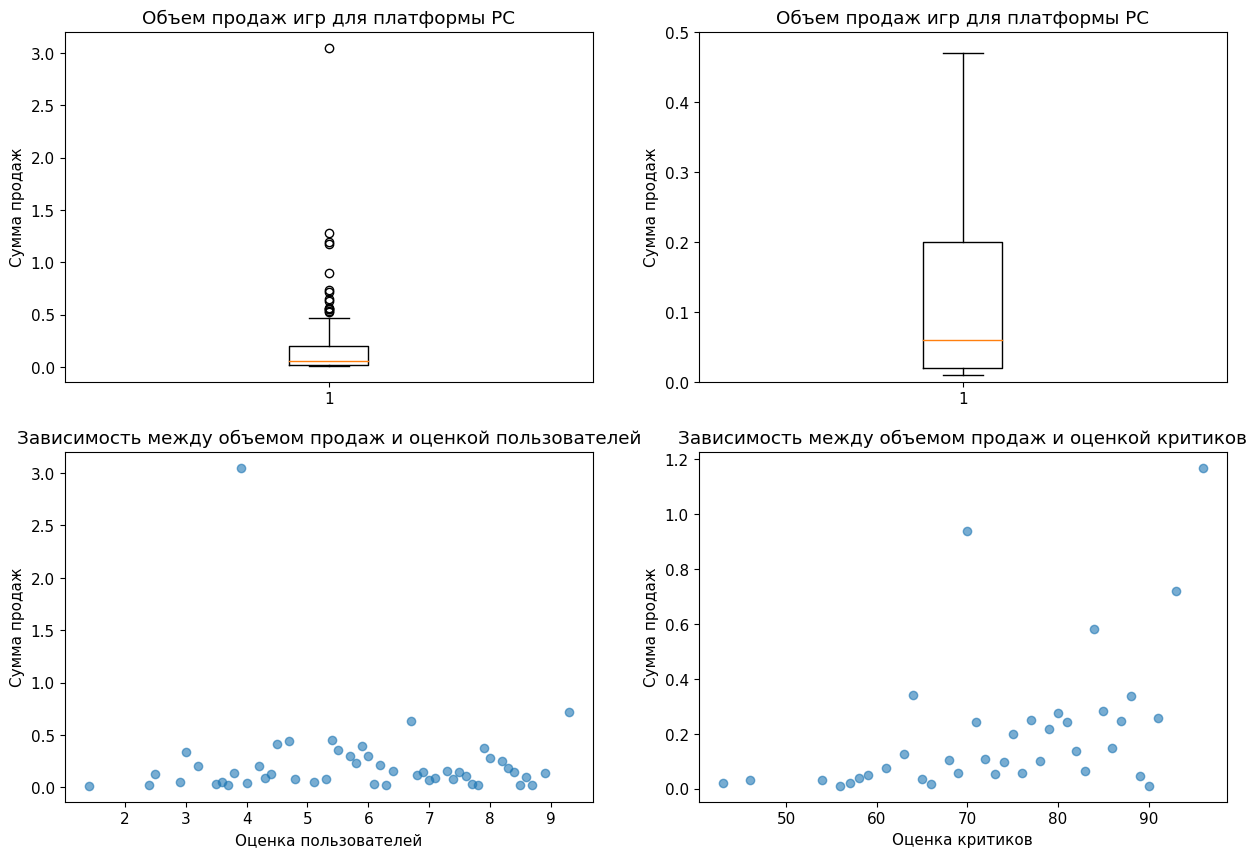

Описательная статистика:
count    151.000000
mean       0.179139
std        0.329359
min        0.010000
25%        0.020000
50%        0.060000
75%        0.200000
max        3.050000
Name: total_sales, dtype: float64

Зависимость между объемом продаж и оценкой пользователей:

              user_score  total_sales
user_score     1.000000    -0.068624
total_sales   -0.068624     1.000000

Зависимость между объемом продаж и оценкой критиков:

               critic_score  total_sales
critic_score       1.00000      0.47435
total_sales        0.47435      1.00000


In [64]:
platform_info("PC",0.5)   

**Вывод**: Для персонального компьютера выпущена 151 игра. Медианное значение объемов продаж составляет 60 тыс. копий. Среднее значение - 179 тысяч, максимальное 3,05 млн.
Корреляция между объемом продаж и оценками критиков средняя, составляет около 0,47. В то же время корреляция между объемом продаж и оценками пользователей крайне слабая - 0,06.

##### Общий Вывод:
Наиболее востребованной платформой в актуальный период на рынке является платформа "PS4", для которой выпущено как максимальное количество игр (376). Продажи игр для данной платформы характеризуются как максимальным средним значением продаж в 766 тысяч, так и максимальным значением продаж одной игры -14,63 млн копий. При этом медианное значение объема продаж составляет 185 тыс. копий.  
На втором месте по востребованности платформа "XOne", для который за актуальный период выпущено 228 игр.  Медианное значение объемов продаж игр для данной платформы составляет 205 тыс. копий, Среднее значение - 616 тысяч, максимальное значение - 7,39 млн. копий.  
Для платформы "3DS" за актуальный период выпущено 212 игр.  Медианное значение объемов продаж составляет 90 тыс. копий, среднее значение - 408 тысяч, наибольший тираж - 11,68 млн. копий.  
Для персонального компьютера была выпущена 151 игра. Медианное значение объемов продаж составляет 60 тыс. копий, среднее значение - 179 тысяч, максимальное - 3,05 млн. копий.  
Для платформы "WiiU" выпущено 73 игры.  Медианное значение объемов продаж игр составляет 190 тыс. копий, среднее значение - 588 тысяч,  наибольший тираж - 7,0 млн. копий.  

В целом по всем платформам отслеживается крайне слабая корреляция между объемом продаж и оценками пользователей. Исключение составляют платформы, востребованные на японском рынке: "3DS" с корреляцией 0,22 и с "WiiU" корреляцией 0,47. 

При этом корреляция между объемом продаж и оценками критиков по всем платформам прослеживается, хоть и не высокая, на уровне 0,5.


#### Исследавание распределения игр по жанрам

Распределения игр по жанрам следует рассмотреть в трех аспектах:
* Общее количество игр представленных в каждом жанре
* Общее количество проданных экземляров игр по каждому из жанров
* Среднее количество проданных игр по каждому из жанров

Для этого формируем соответствующую сводную таблицу.

In [65]:
data_genge = data_act.pivot_table(index = 'genre', values = "total_sales", aggfunc = ['count','sum', 'mean']).reset_index()
data_genge.columns = ['genre', 'count','sum_sales', 'mean_sales']

##### Количество игр представленных в каждом жанре

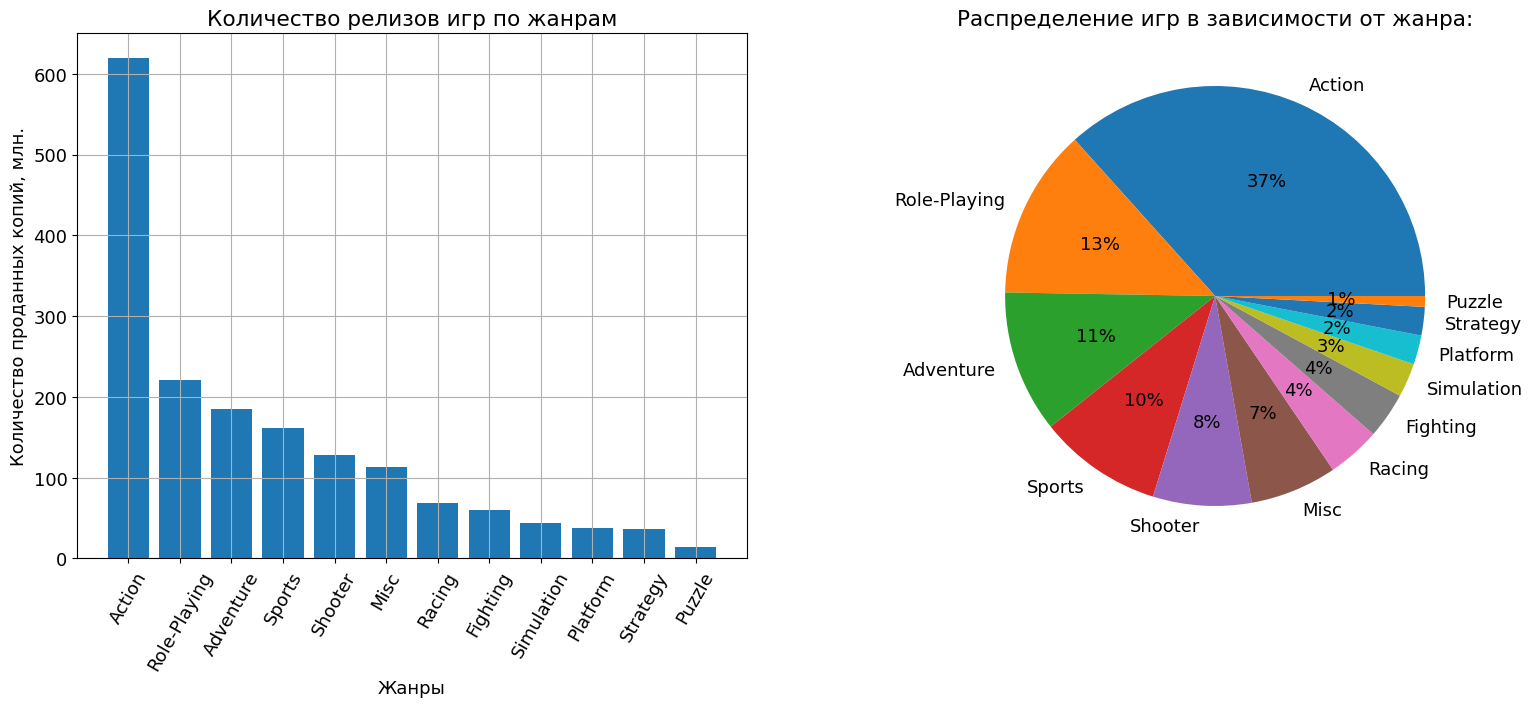

,genre,count
0,Action,619
1,Role-Playing,221
2,Adventure,185
3,Sports,161
4,Shooter,128


In [66]:
data_genge = data_genge.sort_values('count', ascending = False)
plt.figure(figsize=(19,15))
plt.rcParams['font.size'] = 13.0
plt.subplot(2, 2, 1)
plt.bar( data_genge['genre'],data_genge['count'])
plt.grid(b=True)
plt.title('Количество релизов игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество проданных копий, млн.')
plt.xticks(rotation = 60);
plt.subplot(2, 2, 2)
plt.pie(data_genge['count'], labels=data_genge['genre'],autopct='%.0f%%')
plt.title('Распределение игр в зависимости от жанра:');
plt.show()
data_genge[['genre', 'count']].sort_values('count', ascending = False).reset_index(drop = True)[:5]

**Вывод:** В период с 2014 по 2016 год наиболее представленными на рынке игровой индустрии были следующие жанры:

* Action('Экшн') выпущено 619 игр (37% от общего количества),
* Role-playing('Ролевые игры') -  221 игра (13%),
* Adventure('Приключенческие игры') -  185 игрs (11%),
* Sports('Cимуляторы спортивных игр') - 161 игр (10%),
* Shooter('Шутер') -  128 игр (8%),

##### Общее количество проданных экземпляров игр в каждом из жанров

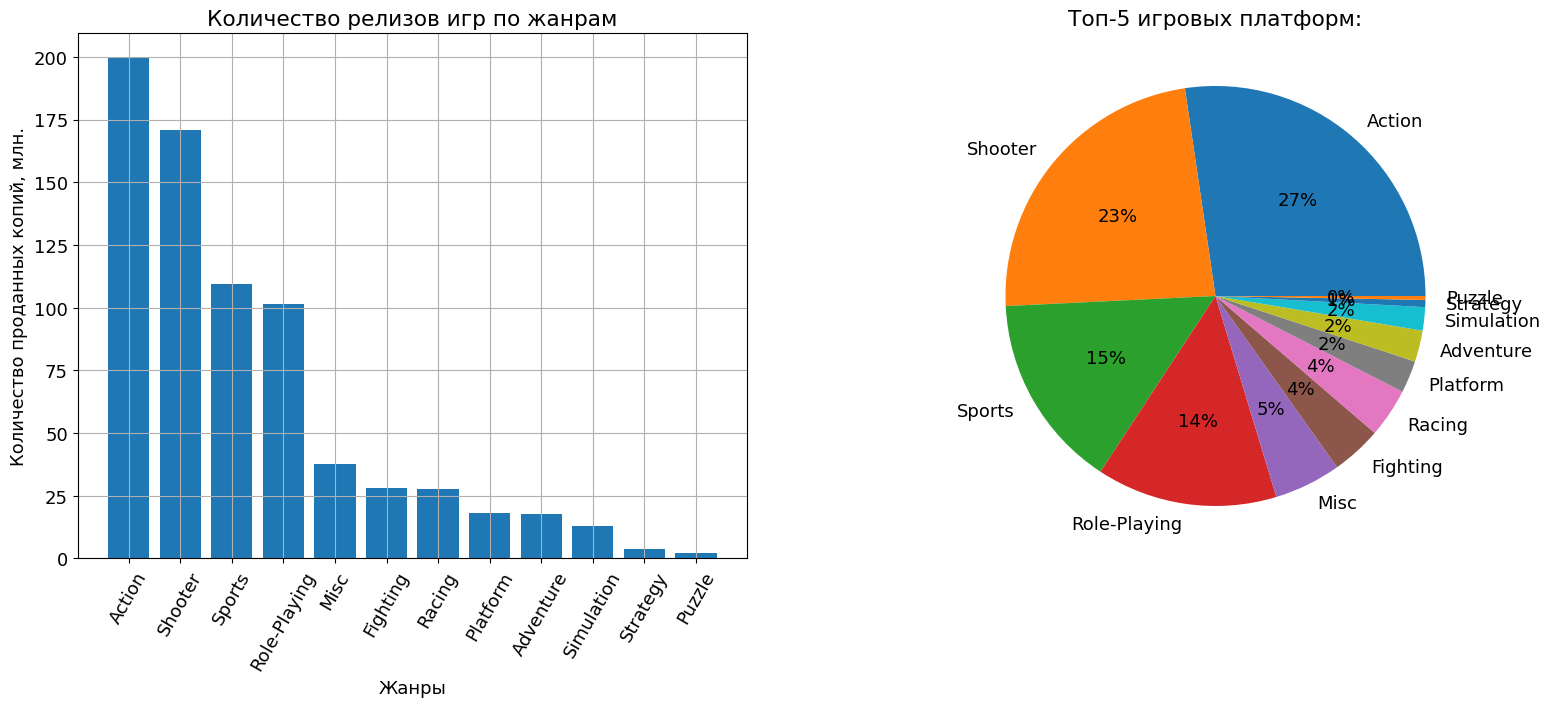

,genre,sum_sales
0,Action,199.36
1,Shooter,170.94
2,Sports,109.48
3,Role-Playing,101.44
4,Misc,37.55


In [67]:
data_genge = data_genge.sort_values('sum_sales', ascending = False)
plt.figure(figsize=(19, 15))
plt.rcParams['font.size'] = 13.0
plt.subplot(2, 2, 1)
plt.bar( data_genge['genre'],data_genge['sum_sales'])
plt.grid(b=True)
plt.title('Количество релизов игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество проданных копий, млн.')
plt.xticks(rotation = 60);
plt.subplot(2, 2, 2)
plt.pie(data_genge['sum_sales'], labels=data_genge['genre'],autopct='%.0f%%')
plt.title('Топ-5 игровых платформ:');

plt.show()
data_genge[['genre', 'sum_sales']].sort_values('sum_sales', ascending = False).reset_index(drop = True)[:5]

 **Вывод:** По общему количеству проданных экземпляров игр топ-5 жанров выглядит следующим образом:

* Action('Экшн') - около 200 млн копий (27% от общего количества),
* Shooter('Шутер') - более 170 млн копий (23%),
* Sports('Cимуляторы спортивных игр') - более 109 млн копий (15%),
* Role-playing('Ролевые игры') - более 101 млн копий (14%),
* Misc - более 37 млн копий (5%)

##### Среднее количество проданных экземпляров игр в каждом из жанров

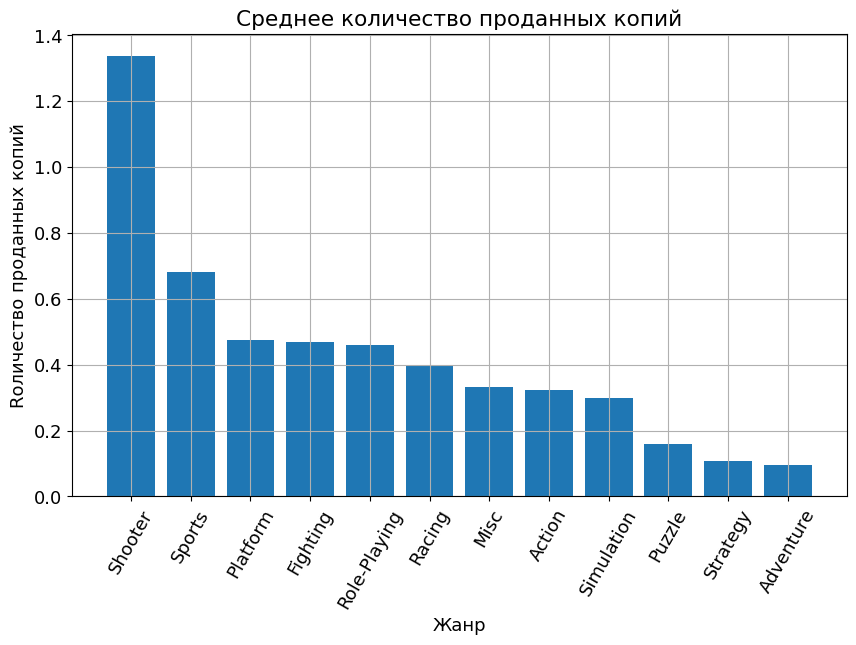

,genre,mean_sales
0,Shooter,1.335469
1,Sports,0.680000
2,Platform,0.476053
3,Fighting,0.470333
4,Role-Playing,0.459005


In [68]:
data_genge = data_genge.sort_values('mean_sales', ascending = False)
plt.figure(figsize=(10, 6))
plt.bar(data_genge['genre'],data_genge['mean_sales'])

plt.grid(b=True)
plt.title('Среднее количество проданных копий')
plt.xlabel('Жанр')
plt.ylabel('Rоличество проданных копий')
plt.xticks(rotation = 60)
plt.show()

data_genge[['genre', 'mean_sales']].sort_values('mean_sales', ascending = False).reset_index(drop = True)[:5]

**Вывод:** По среднему количеству проданных экземпляров игр топ-5 жанров выглядит следующим образом:

* Shooter('Шутер') - в среднем более 1,3 млн копий,
* Sports('Cимуляторы спортивных игр') - в среднем более 680 тысяч копий,
* Platform('Платформер') - в среднем более 476 тысяч копий,
* Fighting('Драки') -в среднем около 470 тысяч копий,
* Role-playing('Ролевые игры') - в среднем более 459 тысяч копий,


##### Общий Вывод:
Основным критерием при определении наиболее перспективных с точки зрения продаж жанров выступает общее количество проданных экземпляров игр за анализируемый период.
С точки зрения разработки дальнейшей рекламной стратегии перспективные жанры можно подразделить на две основные категории:
1. Жанры удерживающие лидерство по  количеству проданных экземпляров  за счет большего «ассортимента» представленных на рынке игр, при этом имеющие сравнительно невысокий уровень среднего  количества проданных экземпляров. К данной категории относятся:
*  Action('Экшн') - самый популярный жанр как с точки зрения общего количества  игр представленных на рынке (619 игр, 37% от общего количества), так и общего количества проданных экземпляров игр (более 200 млн  копий , 27% от общего количества).
* Role-playing('Ролевые игры') – четвертый в рейтинге общего количества проданных экземпляров игр (более 101 млн копий, 14%), второй по популярности жанр по количеству представленных на рынке игр (221игра, 13%).
2. Жанры имеющие высокий показатель количества проданных экземпляров игр за счет высокого среднего количества проданных экземпляров, при этом менее широко представленные на рынке:
*  Shooter('Шутер') – второй в рейтинге    общего количества проданных экземпляров игр (более 170 млн  копий, 23%), первый в рейтинге среднего количества проданных экземпляров -  более 1,3 млн копий на одну игру.
*   Sports('Симуляторы спортивных игр') –  третий по популярности жанр по  общему количеству проданных экземпляров игр(более 109 млн копий, 15%), второй в рейтинге среднего количества проданных экземпляров в -  более 680 тысяч копий на одну игру.


### Составьте портрет пользователя каждого региона

#### Северная америка

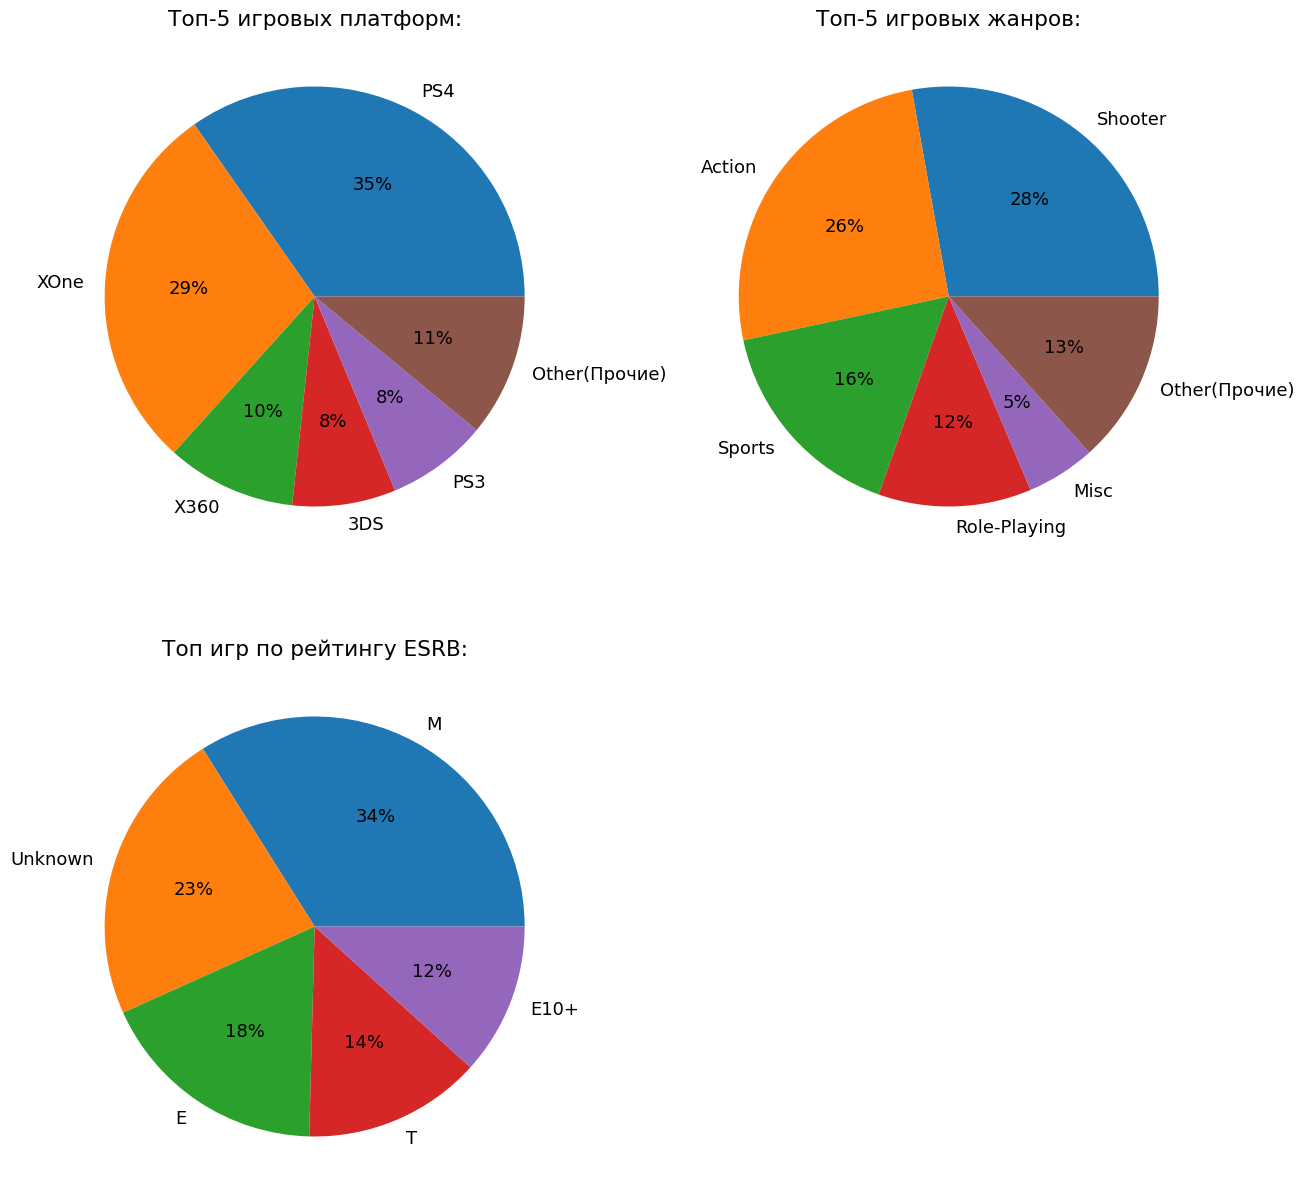

In [69]:
user_portrait('na_sales')

 **Вывод**: Наиболее популярными платформами у жителей Северной Америки в актуальный период времени являются Sony PlayStation 4(35% от объема продаж игр) и  Microsoft Xbox One(29%).Также в рейтинг популярных платформ входят игровые приставки данных производителей предыдущего поколения: Microsoft Xbox 360(10%) и Sony PlayStation 3(8%),   а также  Nintendo 3DS(8%).

Наиболее популярными жанрами являются Shooter('Шутер' -28%) и Action('Экшн' - 26%). Также в рейтинге представлены Sports('Cимуляторы спортивных игр' - 16%), Role-playing('Ролевые игры' - 12%), а также Misc(5%).

В топ игр в соответствии с рейтингом ESRB входят: M(«Для взрослых» - 34%), E(«Для всех возрастов» - 18%), «T»(«Для подростков» - 14%), а также Е10+(Для всех от 10 лет и старше» - 12%). Доля игр с неопределенным рейтингом составляет 23%.


#### Европа

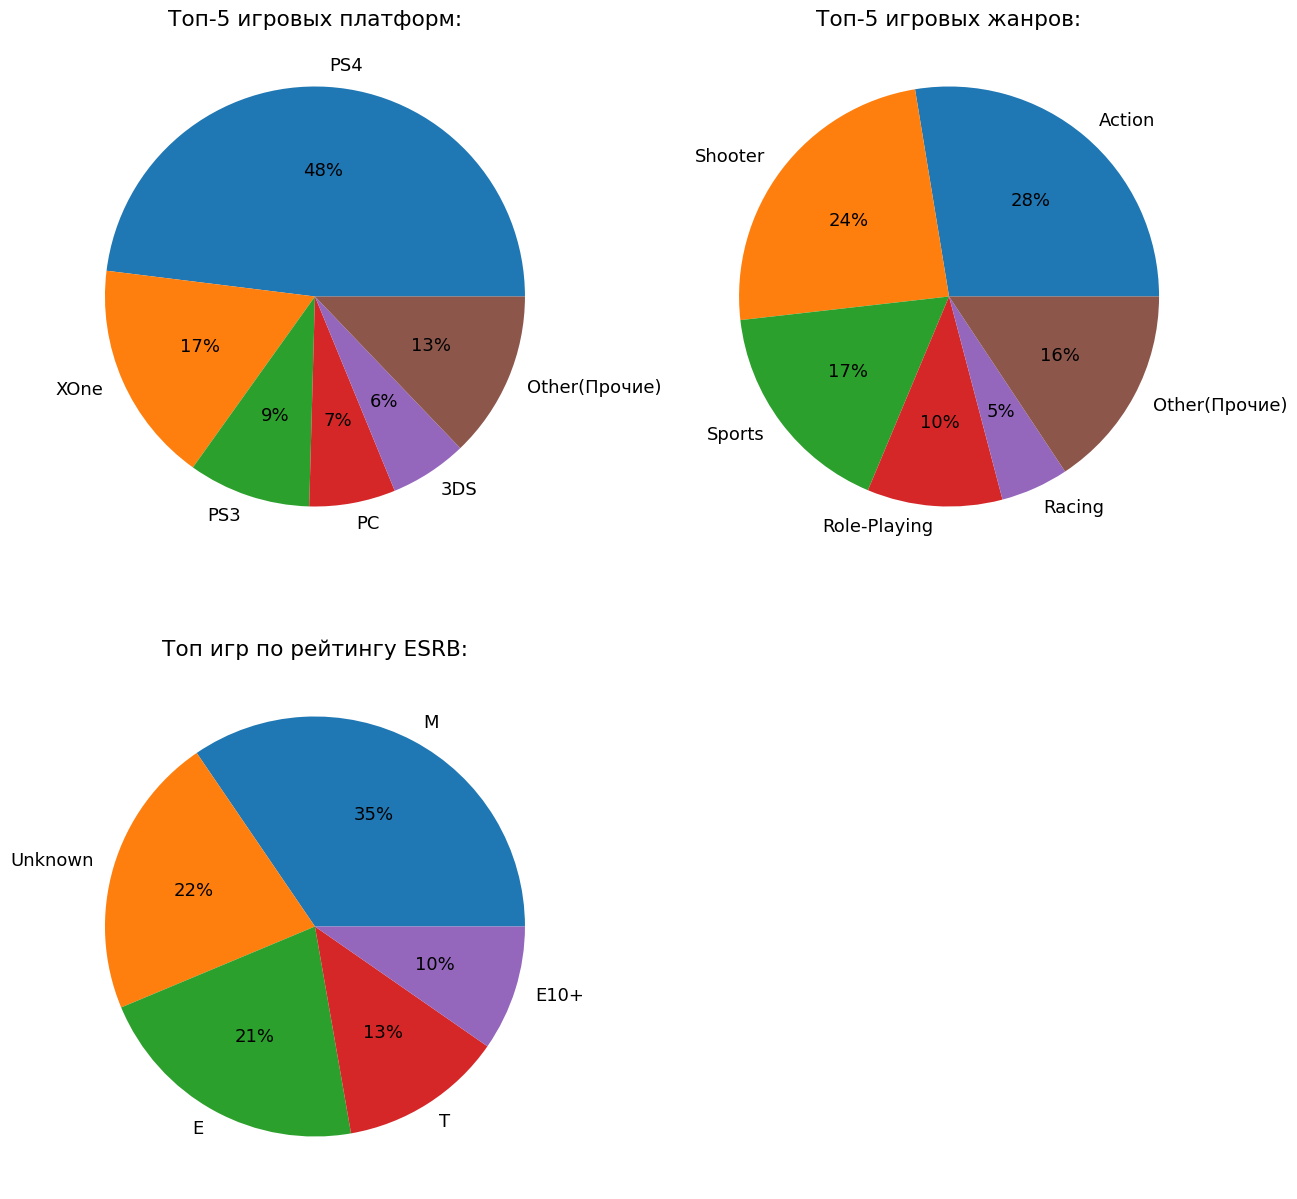

In [70]:
user_portrait('eu_sales')

**Вывод**: 
Наиболее популярными платформами у жителей Европы являются Sony PlayStation 4(48% от объема продаж игр) и  Microsoft Xbox One(17%).Также в рейтинг популярных платформ  представлены Sony PlayStation 3(9%) и PC(7%) и Nintendo 3DS(6%).

Наиболее популярными жанрами являются  Action('Экшн' - 28%) и Shooter('Шутер' - 24%). Также в рейтинге представлены Sports('Cимуляторы спортивных игр' - 17%), Role-playing('Ролевые игры' - 10%), а также Racing('Гонки' - 5%).

В топ игр в соответствии с рейтингом ESRB входят: M(«Для взрослых» - 35%), E(«Для всех возрастов» - 21%), «T»(«Для подростков» - 13%), а также Е10+(Для всех от 10 лет и старше» - 10%).Доля игр с неопределенным рейтингом составляет 22%.

#### Япония

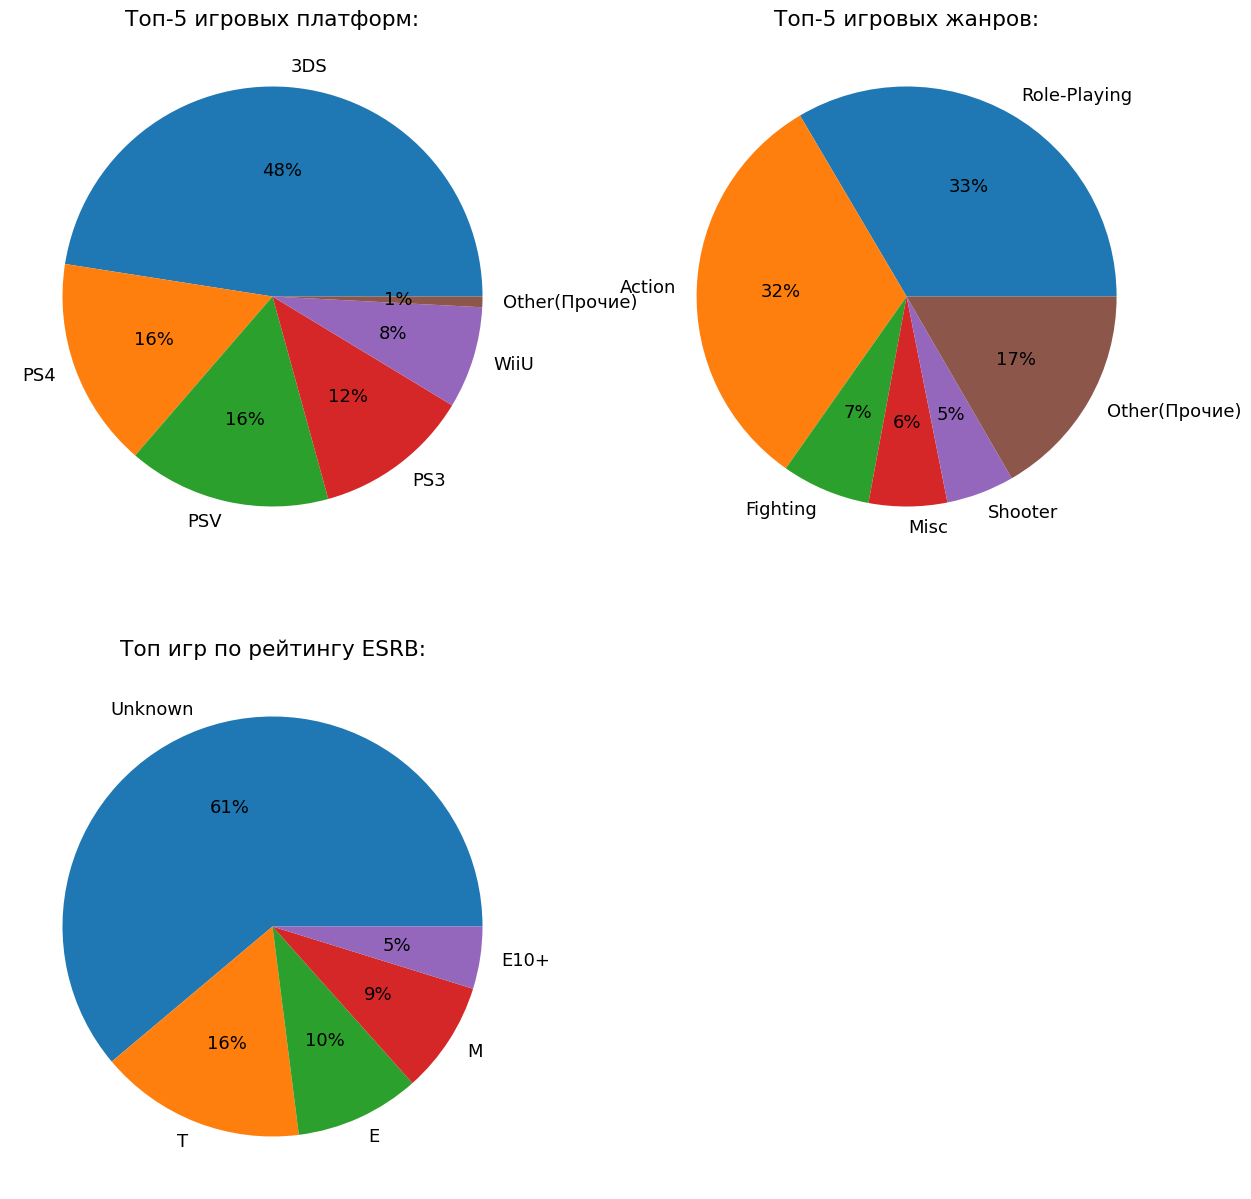

In [71]:
user_portrait('jp_sales')

**Вывод**:  
Наиболее популярной платформой у жителей Японии является Nintendo 3DS(48%). Также в рейтинге представлены различные игровые платформы от компании Sony: Sony PlayStation 4(16%),Sony PlayStation Vita(16%), Sony PlayStation 3(12%), а также  Nintendo Wii U (8%).Обращает на себя внимаение абсолютная невостребованность на рынке игровых платформ от компании Microsoft.

Наиболее популярными жанрами являются Role-playing('Ролевые игры' - 33%), Action('Экшн' - 32%). Также в рейтинге представлены   Fighting('Драки' - 7%),Misc(6%), и Shooter('Шутер' - 5%).

В топ игр в соответствии с рейтингом ESRB входят: «T» («Для подростков» - 16%), E(«Для всех возрастов» - 10%), M(«Для взрослых» - 9%), а также Е10+(Для всех от 10 лет и старше» - 5%). Абсолютное большинство составляют игры с неопределенным рейтингом - 61%.

#### Остальной мир

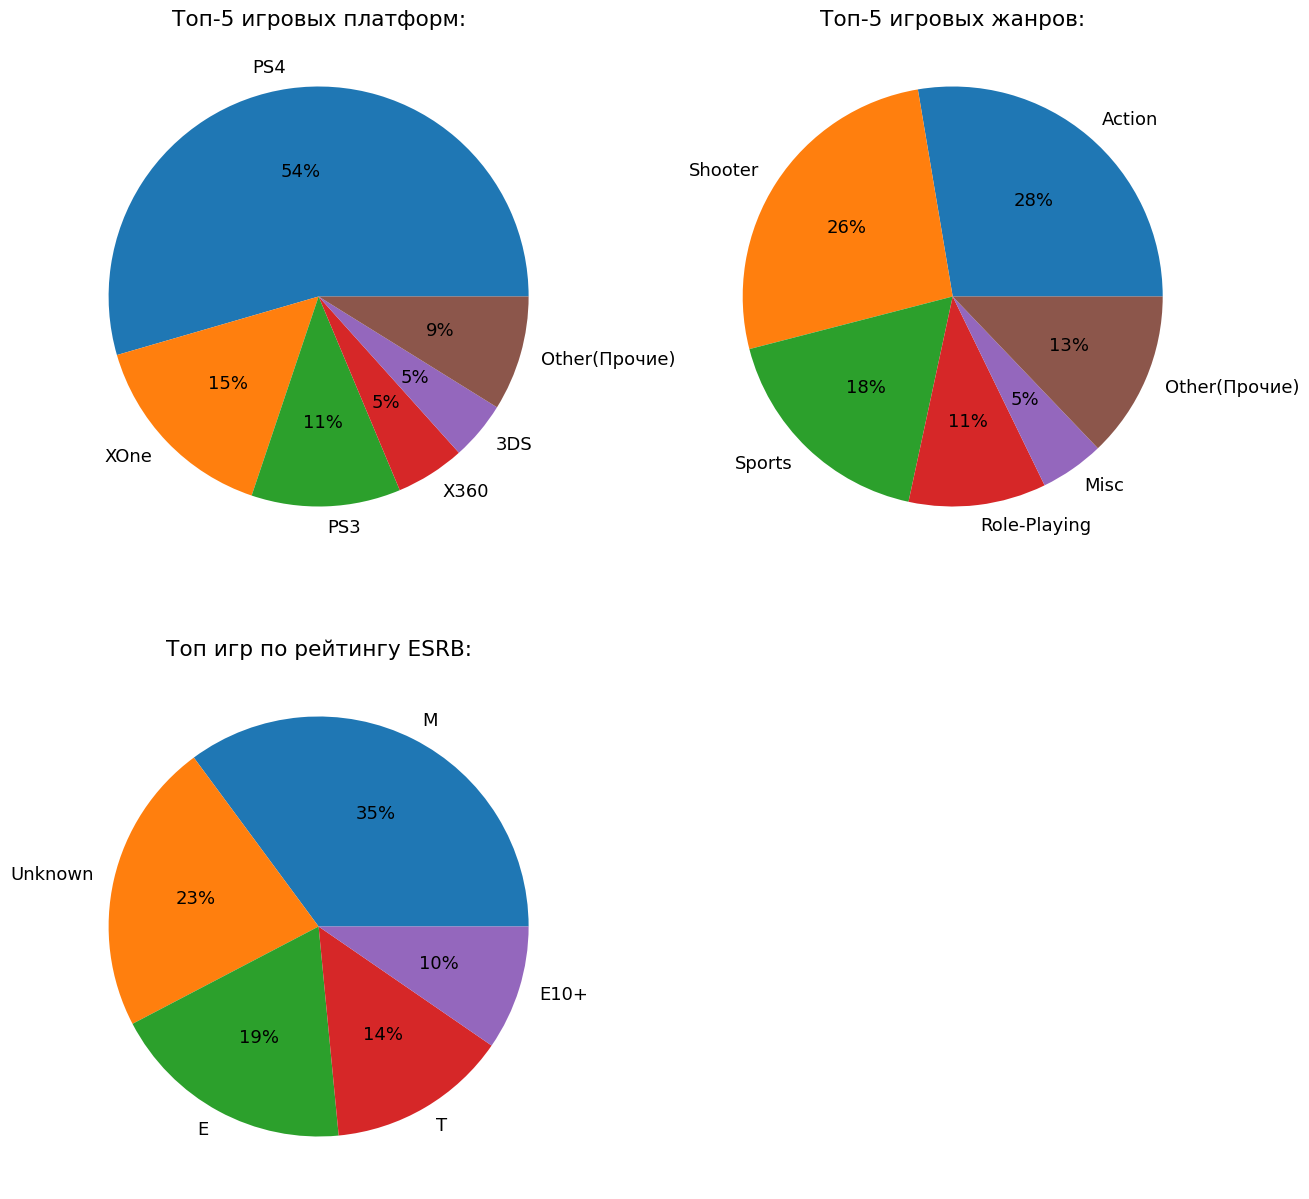

In [72]:
user_portrait('other_sales')

**Вывод**: 
Наиболее популярными платформами у жителей остального мира являются Sony PlayStation 4(54% от объема продаж игр), Microsoft Xbox One(15%) и Sony PlayStation 3(11%) .Также в рейтинг популярных платформ  входят  Microsoft Xbox 360(5%) и Nintendo 3DS(5%).

Наиболее популярными жанрами являются  Action('Экшн' - 28%) и Shooter('Шутер' - 26%). Также в рейтинге представлены Sports('Симуляторы спортивных игр' - 18%), Role-playing('Ролевые игры' - 11%), а также Misc(5%).

В топ игр в соответствии с рейтингом ESRB входят: M(«Для взрослых» - 35%), E(«Для всех возрастов» - 19%), «T» («Для подростков» - 14%), а также Е10+(Для всех от 10 лет и старше» - 10%). Доля игр с неопределенным рейтингом составляет 23%.

#### Общемировые тенденции

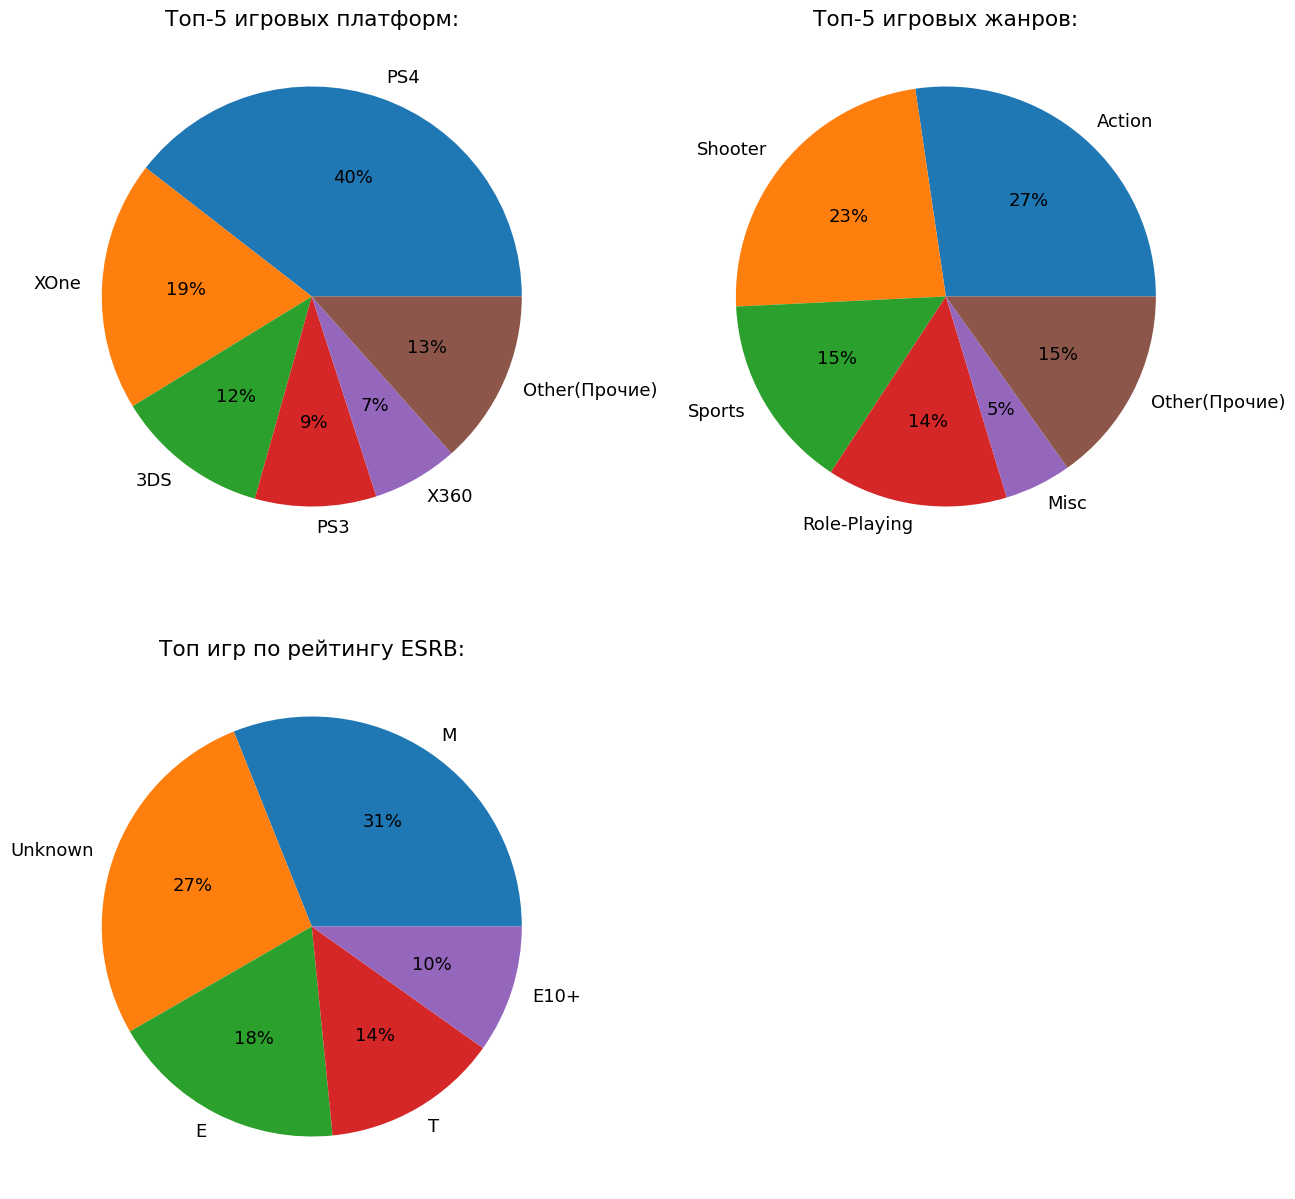

In [73]:
user_portrait('total_sales')

#### Общий вывод:
Для формирования общего вывода, и более отчетливого определения особенностей спроса жителей отдельных регионов, проведена аналитика общемировых тенденций игровой индустрии.  
Наиболее популярными платформами у пользователей являются Sony PlayStation 4(40% от объема продаж игр)и Microsoft Xbox One(19%). Также в рейтинге популярных платформ  представлены Nintendo 3DS(12%), Sony PlayStation 3(9%) и Microsoft Xbox 360(7%)

Наиболее популярными жанрами являются  Action('Экшн' - 27%) и Shooter('Шутер' - 23%). Также в рейтинге представлены Sports('Cимуляторы спортивных игр' - 15%), Role-playing('Ролевые игры' - 14%), а также Misc(5%) .

В топ игр в соответствии с рейтингом ESRB входят: M(«Для взрослых» - 31%), E(«Для всех возрастов» - 18%), «T»(«Для подростков» - 14%), а также Е10+(Для всех от 10 лет и старше» - 10%). Доля игр с неопределенным рейтингом составляет 27%.

Особенности предпочтений у жителей отдельных регионов:
1. Северная Америка. В целом состав популярных игровых платформ совпадает с общемировым. Лидером рейтинга является платформа Sony PlayStation 4(35% от объема продаж игр).  Обращает на себя внимание большая популярность платформ местного производителя - компании Microsoft: Microsoft Xbox One(29%) и Microsoft Xbox 360(10%).  Состав популярных жанров и игр в соответствие с рейтингом ESRB в целом соответствует общемировым тенденциям. С незначичительными отклонениями в процентном соотношении.

2. В Европе более выражено лидерство в рейтинге платформ у Sony PlayStation 4(48% от объема продаж игр). Обращает на себя авнимание отсутствие в топ-5  платформы Microsoft Xbox 360, и присутствие персонального компьютера, сдоле в рейтинге 7%. Рейтинг популярных жанров в целом соответствует общемировому. Единственное различие - пятое место занимают игры жанра Racing(Гонки - 5%). Топ игр в соответствии с рейтингом ESRB входят в целом соответствует общемировым тенденциям.

3. Наибольшие отклонения в предпочтениях проявляют жители Японии. Самой популярной платформой у них является Nintendo 3DS(48%). Также в рейтинге представлены различные игровые платформы от компании Sony: Sony PlayStation 4(16%), Sony PlayStation Vita(16%) и Sony PlayStation 3(12%), а также  Nintendo Wii U (8%).Обращает на себя внимаение абсолютная невостребованность на рынке игровых платформ от компании Microsoft. Также наблюдается различие в востребованности игр в соответствии с их жанрами. Наиболее популярными у жителей Японии жанрами являются Role-playing('Ролевые игры' - 33%) Action('Экшн' - 32%). Также в рейтинге представлены  Fighting('Драки' - 7%), Misc(6%) и Shooter('Шутер' - 5%). В топ игр в соответствии с рейтингом ESRB обращает на себя внимание абсолютное большинство игр с неопределенным рейтингом - 61% , а также относительно высокая доля игр  с рейтингом «T» («Для подростков» - 15%).

4. Состав популярных игровых платформ у жителей остальных регионов мира в целом  совпадает с общемировым. Обращает на себя внимание наиболее прочное лидерство платформы Sony PlayStation 4(54% от объема продаж игр), а также сравнительно малые доли у остальных платформ. Жанровые предпочтения а также предпочтения в соответствие с рейтингом ESRB в целом совпадают с общемировыми тенденциями.


### Проверка гипотез

В ходе исследования необходимо проверить 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотез удалим строки с пропусками в столбце 'user_score'

In [74]:
data_hyp = data_act.dropna(subset=['user_score'])

#### Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC

Сформулируем гипотезы:  
H0 - средние значения пользовательских рейтингов платформ  Xbox One и PC равны.  
Н1 - средние значения пользовательских рейтингов платформ  Xbox One и PC не равны.

Для проверки гипотез из актуального датафрейса сделаем 2 выборки(для каждой из платформ). Так как уверенности в равенстве дисперсий двух выборок нет, задаем параметр "equal_var = True"

In [75]:
xbox = data_hyp.query('platform == "XOne"')['user_score']
pc = data_hyp.query('platform =="PC"')['user_score']

alpha = .05

results = st.ttest_ind(xbox, pc,  equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.11601398086668835
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
По результатам теста не получилось отвегргнуть нулевую гипотезу.
Что в принципе подтверждает, что в современном мире производители оптимизируют и адаптируют игры под различные платформы. И средний рейтинг игры выпущенной на различных платформах существенно  не отличается.

#### Гипотеза о различии средних пользовательских рейтингов жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)

Сформулируем гипотезы:  
H0 - средние значения пользовательских рейтингов жанров Action  и Sports равны.  
Н1 - средние значения пользовательских рейтингов жанров Action  и Sports не равны.

В данном случае проверяемая нами гипотеза будет альтернативной. И в случае отклонения нулевой гипотезы будут основания для принятия гипотезы, проверяемой нами.

In [76]:
action = data_hyp.query('genre == "Action"')['user_score']
sport = data_hyp.query('genre == "Sports"')['user_score']

alpha = .05

results2 = st.ttest_ind(action, sport, equal_var = False)
print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Вывод:**
По результатам теста возникли основания отвергнуть нулевую гипотезу, и принять альтернативную.
Что обуславливается тем, что различия предпочтений пользователей относительно жанра игр обуславливают и различные пользовательские оценки игр различных жанров.


#### Общий вывод:
Обе гипотезы нашли свое подтверждение:
Обе гипотезы нашли свое подтверждение.  
  
Статистического отличия в средних пользовательских рейтинги платформ Xbox One и PC выявлено не было. Так как в настоящее время разработчики игр оптимизируют и адаптируют игры под различные платформы. И средний рейтинг игры выпущенной на различных платформах существенно не отличается. 
  
В ходе сравнения среднего пользовательского рейтинга игр различных жанров выявлены статистические отличия, что позволяет предполагать, что игры разных жанров по-разному востребованы среди пользователей. И имеют различные рейтинги.

### Вывод по проекту:
В ходе проекта проведен анализ исторических данных  о продажах игр, оценках пользователей и экспертов, жанрах, используемых платформах в период до 2016 года.  
  
Целями исследования являлись выявление определяющих успешность игр закономерностей, определение потенциально популярных продуктов с последующим планированием рекламной кампании на 2017 год.  
  
Исходный датафрейм состоял  из 11 столбцов и 16715 строк.  
  
В ходе предобработки данных были проанализированы все столбцы датафрейма. Наименования столбцов приведены в корректный вид.  
  
Удалены строки с пропущенными значениями в столбцах 'name' и 'year_of_release'. В столбце 'rating' пропуски заполнены значением 'Unknown'(рейтинг не определен).  А также откорректирован тип данных по столбцам "year_of_release и "user_score".  
  
В целом по итогам предобработки удалено 1,6% строк.  
  
Этап исследовательского анализа показал следующие результаты:  
  
1.  Общий анализ количества релизов показал,  что в период до 1990 года ежегодное количество выпущенных игр было незначительным.  Явная тенденция к росту стала проявляется с 1991 года. При этом пиковые значения пришлись на 2008-2009 год, в каждый из которых было выпущено более 1400 игр.  

В последующие годы ежегодное количество релизов уменьшилось. С 2012 по 2016 год ежегодное количество игр выпущенных игр стабилизировалось на уровне 600. Снижение количества выпущенных игр с 2009 года может быть обусловлено появлением на рынке мобильных устройств (смартфоны, планшеты), что вызвало как отток пользователей традиционных игровых платформ, так и переориентацию некоторых разработчиков игр на игры для мобильных платформ.  
  
2.  Средний "жизненный цикл" платформы составляет около 10 лет с момента выхода на рынок, при этом во второй половине цикла наблюдается явная отрицательная тенденция в объемах продаж. Для того, чтобы пики продаж по платформам, к 2016 году находящимся на исходе своей популярности, не оказывали влияние на цели исследования, актуальный период должен составлять не более 5 лет.  

Общая ситуация на рынке игровой индустрии  предполагает учитывать только период, когда объем продаж относительно стабилизировался после появления на рынке мобильных устройств.  
  
Также было выявлено резкое падение продаж игр для платформ  Sony PlayStation 3 и Microsoft Xbox 360 в 2014 году, по сравнению с 2013 годом, что вызвано выходом на рынок платформ данных производителей следующего поколения.  
  
Учитывая изложенное принято решение, что для целей исследования подходят данные о продажах игр в период с 2014 по 2016 год.  
  
3. Наиболее перспективными с точки зрения объемов продаж были определены  следующие платформы:  
* "PS4" - Sony PlayStation 4,
* "XOne" - Microsoft Xbox One,
* "3DS" - Nintendo 3DS,
* "WiiU" - Nintendo Wii U,
*  "PC"- персональные компьютеры (данная платформа, не смотря на относительно невысокие объемы продаж, показывает стабильность на всем протяжении развития рынка игровой индустрии).  
  
Наиболее востребованной платформой в актуальный период на рынке являлась Sony PlayStation 4 для которой выпущено максимальное количество игр - 376. Продажи игр для данной платформы характеризуются как максимальным средним значением - 766 тысяч, так и максимальным значением продаж одной игры -14,63 млн копий. При этом медианное значение объема продаж составило 185 тыс. копий.   
  
На втором месте по востребованности платформа " Microsoft Xbox One, для который за актуальный период выпущено 228 игр.  Медианное значение объемов продаж игр для данной платформы составило 205 тыс. копий, среднее значение - 616 тысяч, максимальное значение - 7,39 млн. копий.   
  
Для платформы "3DS" за актуальный период выпущено 212 игр.  Медианное значение объемов продаж составляет 90 тыс. копий, среднее значение - 408 тысяч, наибольший тираж - 11,68 млн. копий.   
  
Для персонального компьютера была выпущена 151 игра. Медианное значение объемов продаж составляет 60 тыс. копий, среднее значение - 179 тысяч, максимальное - 3,05 млн. копий.   
  
Для платформы "WiiU" выпущено 73 игры.  Медианное значение объемов продаж игр составляет 190 тыс. копий, среднее значение - 588 тысяч,  наибольший тираж - 7,0 млн. копий.  
  
В целом по всем платформам отслеживается крайне слабая корреляция между объемом продаж и оценками пользователей. Исключение составляют платформы, востребованные на японском рынке: "3DS и "WiiU" " с корреляцией 0,22  и 0,47 соответственно.  
  
При этом корреляция между объемом продаж и оценками критиков по всем платформам прослеживается на уровне 0,5. 

4. Основным критерием при определении наиболее перспективных с точки зрения продаж жанров выступает общее количество проданных экземпляров игр за анализируемый период.
С точки зрения разработки дальнейшей рекламной стратегии перспективные жанры можно подразделить на две основные категории:  
1) Жанры удерживающие лидерство по  количеству проданных экземпляров  за счет большего «ассортимента» представленных на рынке игр, при этом имеющие сравнительно невысокий уровень среднего  количества проданных экземпляров. К данной категории относятся:
*  Action('Экшн') - самый популярный жанр как с точки зрения общего количества  игр представленных на рынке (619 игр, 37% от общего количества), так и общего количества проданных экземпляров игр (более 200 млн  копий , 27% от общего количества).
* Role-playing('Ролевые игры') – четвертый в рейтинге общего количества проданных экземпляров игр (более 101 млн копий, 14%), второй по популярности жанр по количеству представленных на рынке игр (221игра, 13%).  
2) Жанры имеющие высокий показатель количества проданных экземпляров игр за счет высокого среднего количества проданных экземпляров, при этом менее широко представленные на рынке:
*  Shooter('Шутер') – второй в рейтинге    общего количества проданных экземпляров игр (более 170 млн  копий, 23%), первый в рейтинге среднего количества проданных экземпляров -  более 1,3 млн копий на одну игру.
*   Sports('Симуляторы спортивных игр') –  третий по популярности жанр по  общему количеству проданных экземпляров игр(более 109 млн копий, 15%), второй в рейтинге среднего количества проданных экземпляров в -  более 680 тысяч копий на одну игру.


  
5. Для более отчетливого определения особенностей спроса жителей отдельных регионов, проведена аналитика общемировых тенденций  игровой индустрии.  
  
Наиболее популярными платформами у пользователей являются Sony PlayStation 4 (40% от объема продаж игр) и Microsoft Xbox One(19%). Также в рейтинге популярных платформ  представлены Nintendo 3DS(12%), Sony PlayStation 3(9%) и Microsoft Xbox 360(7%).  
  
Наиболее популярными жанрами являлись Action(Экшн - 27%) и Shooter(Шутер - 23%). Также в рейтинге представлены Sports(симуляторы спортивных игр - 15%), Role-playing(Ролевые игры - 14%), а также Misc(5%).  
  
В топ игр в соответствии с рейтингом ESRB входят: M(«Для взрослых» - 31%), E(«Для всех возрастов» - 18%), «T»(«Для подростков» - 14%), а также Е10+(Для всех от 10 лет и старше» - 10%). Доля игр с неопределенным рейтингом составляет 27%.  
  
Особенности предпочтений у жителей отдельных регионов:  
  
1) Северная Америка. В целом состав популярных игровых платформ совпадает с общемировым. Лидером рейтинга является платформа Sony PlayStation 4(35% от объема продаж игр).  Обращает на себя внимание большая популярность платформ местного производителя - компании Microsoft: Microsoft Xbox One(29%) и Microsoft Xbox 360(10%).  Состав популярных жанров и игр в соответствие с рейтингом ESRB в целом соответствует общемировым тенденциям. С незначительными отклонениями в процентном соотношении.  
  
2) В Европе более выражено лидерство в рейтинге платформ у Sony PlayStation 4(48% от объема продаж игр). Обращает на себя внимание отсутствие в топ-5  платформы Microsoft Xbox 360, и присутствие персонального компьютера, с долей в рейтинге 7%. Рейтинг популярных жанров в целом соответствует общемировому. Единственное различие - пятое место занимают игры жанра Racing(Гонки - 5%). Топ игр в соответствии с рейтингом ESRB входят в целом соответствует общемировым тенденциям.  
  
3)  Наибольшие отклонения в предпочтениях проявляют жители Японии. Самой популярной платформой у них является Nintendo 3DS(48%). Также в рейтинге представлены различные игровые платформы от компании Sony: Sony PlayStation 4(16%), Sony PlayStation Vita(16%) и Sony PlayStation 3(12%), а также  Nintendo Wii U (8%).Обращает на себя внимание абсолютная невостребованность на рынке игровых платформ от компании Microsoft. Также наблюдается различие в востребованности игр в соответствии с их жанрами. Наиболее популярными у жителей Японии жанрами являются Role-playing(Ролевые игры - 33%) Action(Экшн - 32%). Также в рейтинге представлены Fighting(Драки - 7%), Misc(6%) и Shooter(Шутер - 5%). В топ игр в соответствии с рейтингом ESRB обращает на себя внимание абсолютное большинство игр с неопределенным рейтингом - 61% , а также относительно высокая доля игр  с рейтингом «T» («Для подростков» - 15%).  
  
4) Состав популярных игровых платформ у жителей остальных регионов мира в целом  совпадает с общемировым. Обращает на себя внимание наиболее прочное лидерство платформы Sony PlayStation 4(54% от объема продаж игр), а также сравнительно малые доли у остальных платформ. Жанровые предпочтения а также предпочтения в соответствие с рейтингом ESRB в целом совпадают с общемировыми тенденциями.


 В ходе исследования были проверены 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.  
  
Обе гипотезы нашли свое подтверждение.  
  
Статистического отличия в средних пользовательских рейтинги платформ Xbox One и PC выявлено не было. Так как в настоящее время разработчики игр оптимизируют и адаптируют игры под различные платформы. И средний рейтинг игры выпущенной на различных платформах существенно не отличается. 
  
В ходе сравнения среднего пользовательского рейтинга игр различных жанров выявлены статистические отличия, что позволяет предполагать, что игры разных жанров по-разному востребованы среди пользователей. И имеют различные рейтинги.

***Рекомендация:*** При планировании рекламной стратегии на 2017 год необходимо учитывать региональные особенности пользователей. Особенно следует обратить внимание на Японию, так как пользовательские предпочтения в данной стране сильно отличаются от общемировых тенденций как в плантформенном, жанровом, так и в рейтинговом(ESRB) отношении.
